In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import sys
from pathlib import Path
import torch
import timm
import warnings

from scripts.dataset import CalorieDataset, create_data_loaders, get_transforms
from scripts.utils import (
    CaloriePredictor, 
    create_optimizer_and_scheduler, 
    train_epoch, 
    validate_epoch,
    seed_everything
)
import yaml
import time
from tqdm.auto import tqdm

s:\yandex\calorie-vision\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings('ignore')

# –≠—Ç–∞–ø 1. –ò—Å—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å—Å–∫–∏–π –∞–Ω–∞–ª–∏–∑ (EDA)

In [3]:
# –ù–∞—Å—Ç—Ä–æ–π–∫–∞ —Å—Ç–∏–ª—è –≥—Ä–∞—Ñ–∏–∫–æ–≤
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [4]:
# –ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö
print("–ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö...")
dish_df = pd.read_csv('data/dish.csv')
ingredients_df = pd.read_csv('data/ingredients.csv')

–ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö...


In [5]:
dish_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dish_id         3262 non-null   object 
 1   total_calories  3262 non-null   float64
 2   total_mass      3262 non-null   float64
 3   ingredients     3262 non-null   object 
 4   split           3262 non-null   object 
dtypes: float64(2), object(3)
memory usage: 127.5+ KB


–ü—Ä–æ–ø—É—Å–∫–æ–≤ –Ω–µ—Ç

In [6]:
ingredients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      555 non-null    int64 
 1   ingr    555 non-null    object
dtypes: int64(1), object(1)
memory usage: 8.8+ KB


–ü—Ä–æ–ø—É—Å–∫–æ–≤ –Ω–µ—Ç

In [7]:
print("\n–ü–µ—Ä–≤—ã–µ —Å—Ç—Ä–æ–∫–∏ –¥–∞—Ç–∞—Å–µ—Ç–∞ –±–ª—é–¥:")
dish_df.head()


–ü–µ—Ä–≤—ã–µ —Å—Ç—Ä–æ–∫–∏ –¥–∞—Ç–∞—Å–µ—Ç–∞ –±–ª—é–¥:


dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   

                                         ingredients  split  
0  ingr_0000000508;ingr_0000000122;ingr_000000002...   test  
1  ingr_0000000312;ingr_0000000026;ingr_000000002...  train  
2  ingr_0000000448;ingr_0000000520;ingr_000000046...   test  
3    ingr_0000000471;ingr_0000000031;ingr_0000000347  train  
4                                    ingr_0000000453  train

In [8]:
print("\n–ü–µ—Ä–≤—ã–µ —Å—Ç—Ä–æ–∫–∏ –¥–∞—Ç–∞—Å–µ—Ç–∞ –∏–Ω–≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤:")
ingredients_df.head()


–ü–µ—Ä–≤—ã–µ —Å—Ç—Ä–æ–∫–∏ –¥–∞—Ç–∞—Å–µ—Ç–∞ –∏–Ω–≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤:


id            ingr
0   1  cottage cheese
1   2    strawberries
2   3    garden salad
3   4           bacon
4   5        potatoes

–ü–æ–∏—Å–∫ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤

In [9]:
dish_df.duplicated().mean(), ingredients_df.duplicated().mean()

(np.float64(0.0), np.float64(0.0))

–ü–æ–ª–Ω—ã—Ö –¥—É–±–ª–∏–∫–∞—Ç–æ–≤ –Ω–µ—Ç

In [10]:
dish_df["dish_id"].duplicated().mean(), ingredients_df["id"].duplicated().mean()

(np.float64(0.0), np.float64(0.0))

–î—É–±–ª–∏–∫–∞—Ç–æ–≤ dish_id –∏ id –Ω–µ—Ç

In [11]:
ingredients_df["ingr"].duplicated().mean()

np.float64(0.005405405405405406)

–ï—Å—Ç—å –¥—É–±–ª–∏–∫–∞—Ç—ã –¥–ª—è ingr

In [12]:
ingredients_df[ingredients_df["ingr"].duplicated()]

id        ingr
452  453  deprecated
457  458  deprecated
469  470  deprecated

3 –∏–Ω–≥—Ä–∞–¥–∏–µ–Ω—Ç–∞ —è–≤–ª—è—é—Ç—Å—è —É—Å—Ç–∞—Ä–µ–≤—à–∏–º–∏

–£–¥–∞–ª–∏–º —ç—Ç–∏ –¥–∞–Ω–Ω—ã–µ –∏–∑ 2 –¥–∞—Ç–∞—Å–µ—Ç–æ–≤

In [13]:
# –ù–∞—Ö–æ–¥–∏–º deprecated –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç—ã
deprecated_ids = ingredients_df[ingredients_df["ingr"] == "deprecated"]["id"].values
deprecated_ids_str = [f"ingr_{id:010d}" for id in deprecated_ids]

print(f"Deprecated –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç—ã: {deprecated_ids}")
print(f"Deprecated ID —Å—Ç—Ä–æ–∫–∏: {deprecated_ids_str}")

# –ù–∞—Ö–æ–¥–∏–º –±–ª—é–¥–∞ —Å deprecated –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–∞–º–∏
dishes_to_remove = []
for idx, row in dish_df.iterrows():
    ingredients_list = row['ingredients'].split(';')
    for ingr in ingredients_list:
        if ingr in deprecated_ids_str:
            dishes_to_remove.append(row['dish_id'])
            break

print(f"–ë–ª—é–¥ —Å deprecated –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–∞–º–∏: {len(dishes_to_remove)}")

# –£–¥–∞–ª—è–µ–º —ç—Ç–∏ –±–ª—é–¥–∞
dish_df = dish_df[~dish_df['dish_id'].isin(dishes_to_remove)].copy()

print(f"–ò—Å—Ö–æ–¥–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ: {len(dish_df) + len(dishes_to_remove)}")
print(f"–ü–æ—Å–ª–µ —É–¥–∞–ª–µ–Ω–∏—è: {len(dish_df)}")
print(f"–£–¥–∞–ª–µ–Ω–æ: {len(dishes_to_remove)}")

# –ü—Ä–æ–≤–µ—Ä—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç
print(f"\n–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ —Å–ø–ª–∏—Ç–∞–º:")
print(dish_df['split'].value_counts())

Deprecated –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç—ã: [231 453 458 470]
Deprecated ID —Å—Ç—Ä–æ–∫–∏: ['ingr_0000000231', 'ingr_0000000453', 'ingr_0000000458', 'ingr_0000000470']
–ë–ª—é–¥ —Å deprecated –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–∞–º–∏: 31
–ò—Å—Ö–æ–¥–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ: 3262
–ü–æ—Å–ª–µ —É–¥–∞–ª–µ–Ω–∏—è: 3231
–£–¥–∞–ª–µ–Ω–æ: 31

–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ —Å–ø–ª–∏—Ç–∞–º:
split
train    2732
test      499
Name: count, dtype: int64


In [14]:
ingredients_df = ingredients_df[ingredients_df["ingr"] != "deprecated"]
ingredients_df[ingredients_df["ingr"].duplicated()]

Empty DataFrame
Columns: [id, ingr]
Index: []

In [15]:
print("\n–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –ø–æ —á–∏—Å–ª–æ–≤—ã–º –ø—Ä–∏–∑–Ω–∞–∫–∞–º:")
dish_df.describe()


–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –ø–æ —á–∏—Å–ª–æ–≤—ã–º –ø—Ä–∏–∑–Ω–∞–∫–∞–º:


total_calories   total_mass
count     3231.000000  3231.000000
mean       255.250275   215.185392
std        219.004133   161.987054
min          0.000000     1.000000
25%         81.352211    92.000000
50%        209.934982   177.000000
75%        375.263992   305.000000
max       3943.325195  3051.000000

–ú–∏–Ω–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–∞–ª–æ—Ä–∏–π —Ä–∞–≤–Ω–æ 0, —á—Ç–æ —Å—Ç—Ä–∞–Ω–Ω–æ. –¢–∞–∫–∂–µ –µ—Å—Ç—å –±–ª—é–¥–∞ —Å –º–∞—Å—Å–æ–π 1 –≥—Ä–∞–º–º, —á—Ç–æ  —Ç–æ–∂–µ —Å—Ç—Ä–∞–Ω–Ω–æ.

In [16]:
dish_df[dish_df["total_calories"] == 0]

dish_id  total_calories  total_mass      ingredients  split
263   dish_1557861216             0.0         1.0  ingr_0000000423   test
2652  dish_1556575700             0.0        86.0  ingr_0000000423  train

–¢–∞–∫–∏—Ö 2 –±–ª—é–¥–∞ c 1 –∏–≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–º ingr_0000000423. –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –Ω–µ–≥–æ

In [17]:
ingredients_df[ingredients_df["id"] == 423]

id        ingr
422  423  plate only

–≠—Ç–æ –ø—É—Å—Ç–∞—è —Ç–∞—Ä–µ–ª–∫–∞

–ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –±–ª—é–¥–æ —Å –º–∞—Å—Å–æ–π 1 –≥—Ä–∞–º–º

In [18]:
dish_df[dish_df["total_mass"] == 1]

dish_id  total_calories  total_mass      ingredients split
263  dish_1557861216             0.0         1.0  ingr_0000000423  test

–≠—Ç–æ —Ç–æ–∂–µ –ø—É—Å—Ç–∞—è —Ç–∞—Ä–µ–ª–∫–∞. –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –≤—Å–µ –±–ª—é–¥–∞ —Å –ø—É—Å—Ç–æ–π —Ç–∞—Ä–µ–ª–∫–æ–π

In [19]:
dish_df[dish_df["ingredients"] == "ingr_0000000423"]

dish_id  total_calories  total_mass      ingredients  split
263   dish_1557861216             0.0         1.0  ingr_0000000423   test
2652  dish_1556575700             0.0        86.0  ingr_0000000423  train

–¢–∞–∫–∏—Ö 2 –ª–±–ª—é–¥–∞. –°—Ç—Ä–∞–Ω–Ω–æ, —á—Ç–æ –¥–ª—è –ø—É—Å—Ç–æ–π —Ç–∞—Ä–µ–ª–∫–∏ –≤ –±–ª—é–¥–µ dish_1556575700 –≤–µ—Å —É–∫–∞–∑–∞–Ω –∫–∞–∫ 86 –≥—Ä–∞–º–º. –ü–æ—Ö–æ–∂–µ –Ω–∞ –æ—à–∏–±–∫—É

–£–¥–∞–ª–∏–º —ç—Ç—É –∑–∞–ø–∏—Å—å

In [20]:
dish_df = dish_df[dish_df["dish_id"] != "dish_1556575700"]
dish_df[dish_df["ingredients"] == "ingr_0000000423"]

dish_id  total_calories  total_mass      ingredients split
263  dish_1557861216             0.0         1.0  ingr_0000000423  test

–ê–Ω–∞–ª–∏–∑ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –¥–∞–Ω–Ω—ã—Ö –ø–æ —Å–ø–ª–∏—Ç–∞–º

In [21]:
print("\n=== –†–ê–°–ü–†–ï–î–ï–õ–ï–ù–ò–ï –ü–û –°–ü–õ–ò–¢–ê–ú ===")
split_counts = dish_df['split'].value_counts()
print(split_counts)
print(f"–ü—Ä–æ—Ü–µ–Ω—Ç–Ω–æ–µ —Å–æ–æ—Ç–Ω–æ—à–µ–Ω–∏–µ train/test: {split_counts['train']/len(dish_df)*100:.1f}% / {split_counts['test']/len(dish_df)*100:.1f}%")


=== –†–ê–°–ü–†–ï–î–ï–õ–ï–ù–ò–ï –ü–û –°–ü–õ–ò–¢–ê–ú ===
split
train    2731
test      499
Name: count, dtype: int64
–ü—Ä–æ—Ü–µ–Ω—Ç–Ω–æ–µ —Å–æ–æ—Ç–Ω–æ—à–µ–Ω–∏–µ train/test: 84.6% / 15.4%


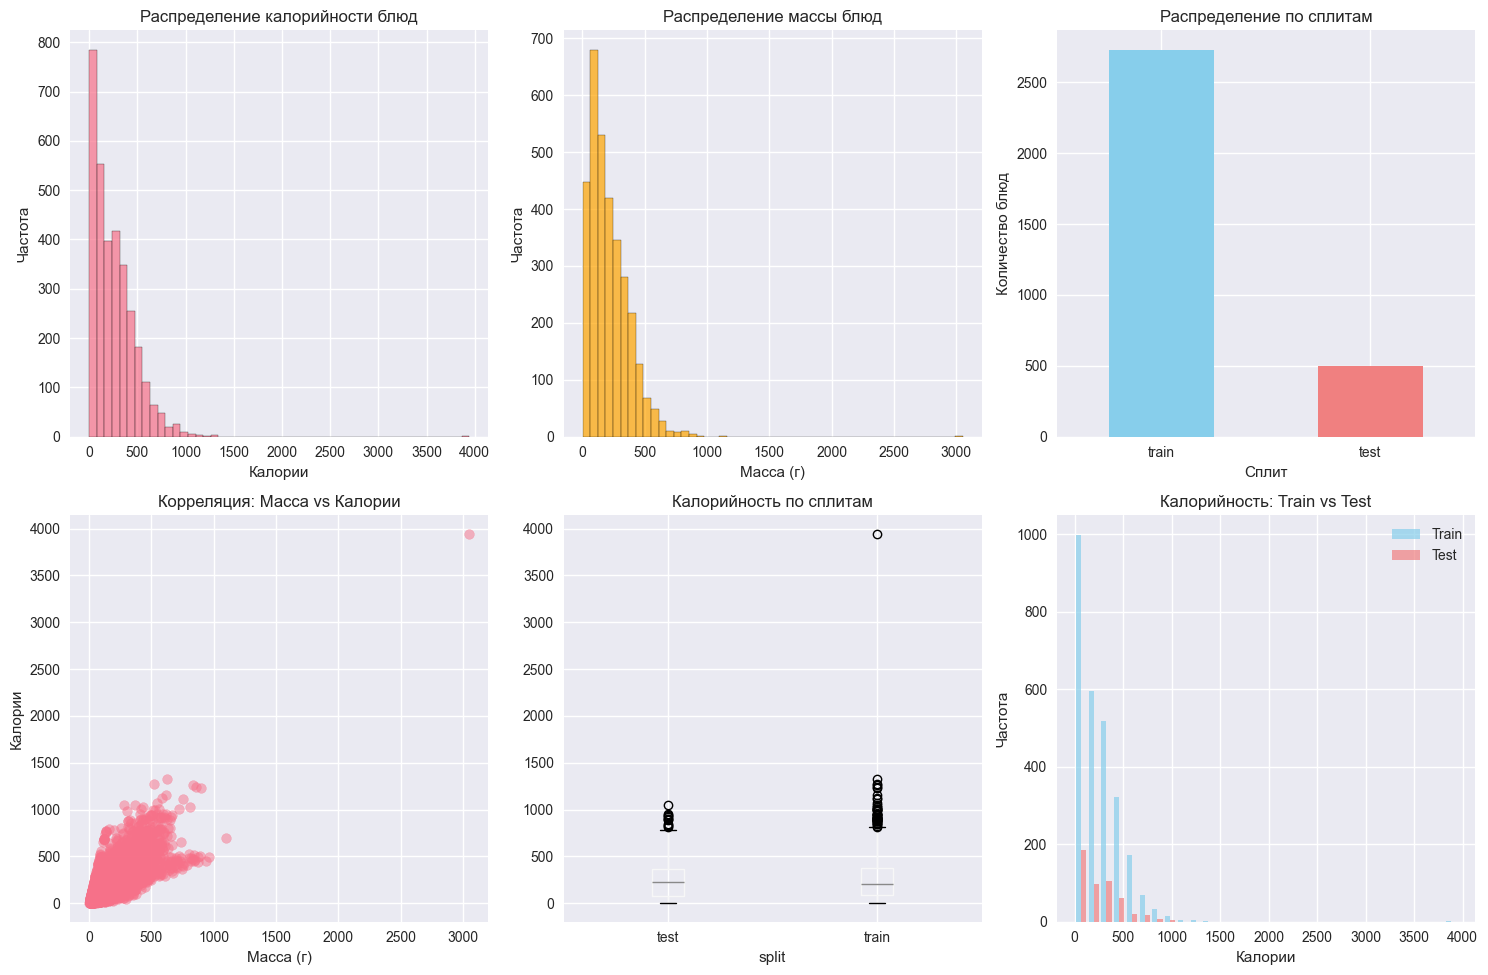

In [22]:
# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –∫–∞–ª–æ—Ä–∏–π–Ω–æ—Å—Ç–∏
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(dish_df['total_calories'], bins=50, alpha=0.7, edgecolor='black')
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–∞–ª–æ—Ä–∏–π–Ω–æ—Å—Ç–∏ –±–ª—é–¥')
plt.xlabel('–ö–∞–ª–æ—Ä–∏–∏')
plt.ylabel('–ß–∞—Å—Ç–æ—Ç–∞')

plt.subplot(2, 3, 2)
plt.hist(dish_df['total_mass'], bins=50, alpha=0.7, edgecolor='black', color='orange')
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –º–∞—Å—Å—ã –±–ª—é–¥')
plt.xlabel('–ú–∞—Å—Å–∞ (–≥)')
plt.ylabel('–ß–∞—Å—Ç–æ—Ç–∞')

plt.subplot(2, 3, 3)
# –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ —Å–ø–ª–∏—Ç–∞–º
split_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ —Å–ø–ª–∏—Ç–∞–º')
plt.xlabel('–°–ø–ª–∏—Ç')
plt.ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –±–ª—é–¥')
plt.xticks(rotation=0)

plt.subplot(2, 3, 4)
# –ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –º–µ–∂–¥—É –º–∞—Å—Å–æ–π –∏ –∫–∞–ª–æ—Ä–∏—è–º–∏
plt.scatter(dish_df['total_mass'], dish_df['total_calories'], alpha=0.5)
plt.title('–ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è: –ú–∞—Å—Å–∞ vs –ö–∞–ª–æ—Ä–∏–∏')
plt.xlabel('–ú–∞—Å—Å–∞ (–≥)')
plt.ylabel('–ö–∞–ª–æ—Ä–∏–∏')

plt.subplot(2, 3, 5)
# Box plot –∫–∞–ª–æ—Ä–∏–π–Ω–æ—Å—Ç–∏ –ø–æ —Å–ø–ª–∏—Ç–∞–º
dish_df.boxplot(column='total_calories', by='split', ax=plt.gca())
plt.title('–ö–∞–ª–æ—Ä–∏–π–Ω–æ—Å—Ç—å –ø–æ —Å–ø–ª–∏—Ç–∞–º')
plt.suptitle('')  # –£–±–∏—Ä–∞–µ–º –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∏–π –∑–∞–≥–æ–ª–æ–≤–æ–∫

plt.subplot(2, 3, 6)
# –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–∞–ª–æ—Ä–∏–π–Ω–æ—Å—Ç–∏ –ø–æ —Å–ø–ª–∏—Ç–∞–º
train_calories = dish_df[dish_df['split'] == 'train']['total_calories']
test_calories = dish_df[dish_df['split'] == 'test']['total_calories']
plt.hist([train_calories, test_calories], bins=30, alpha=0.7, 
         label=['Train', 'Test'], color=['skyblue', 'lightcoral'])
plt.title('–ö–∞–ª–æ—Ä–∏–π–Ω–æ—Å—Ç—å: Train vs Test')
plt.xlabel('–ö–∞–ª–æ—Ä–∏–∏')
plt.ylabel('–ß–∞—Å—Ç–æ—Ç–∞')
plt.legend()

plt.tight_layout()
plt.show()

–ê–Ω–∞–ª–∏–∑ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤

In [23]:
print("\n=== –ê–ù–ê–õ–ò–ó –ò–ù–ì–†–ï–î–ò–ï–ù–¢–û–í ===")
dish_df['ingredient_count'] = dish_df['ingredients'].apply(lambda x: len(x.split(';')))
print(f"–°—Ä–µ–¥–Ω–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤: {dish_df['ingredient_count'].mean():.2f}")
print(f"–ú–µ–¥–∏–∞–Ω–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤: {dish_df['ingredient_count'].median():.2f}")
print(f"–ú–∏–Ω–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤: {dish_df['ingredient_count'].min()}")
print(f"–ú–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤: {dish_df['ingredient_count'].max()}")


=== –ê–ù–ê–õ–ò–ó –ò–ù–ì–†–ï–î–ò–ï–ù–¢–û–í ===
–°—Ä–µ–¥–Ω–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤: 7.36
–ú–µ–¥–∏–∞–Ω–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤: 4.00
–ú–∏–Ω–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤: 1
–ú–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤: 34


–í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤

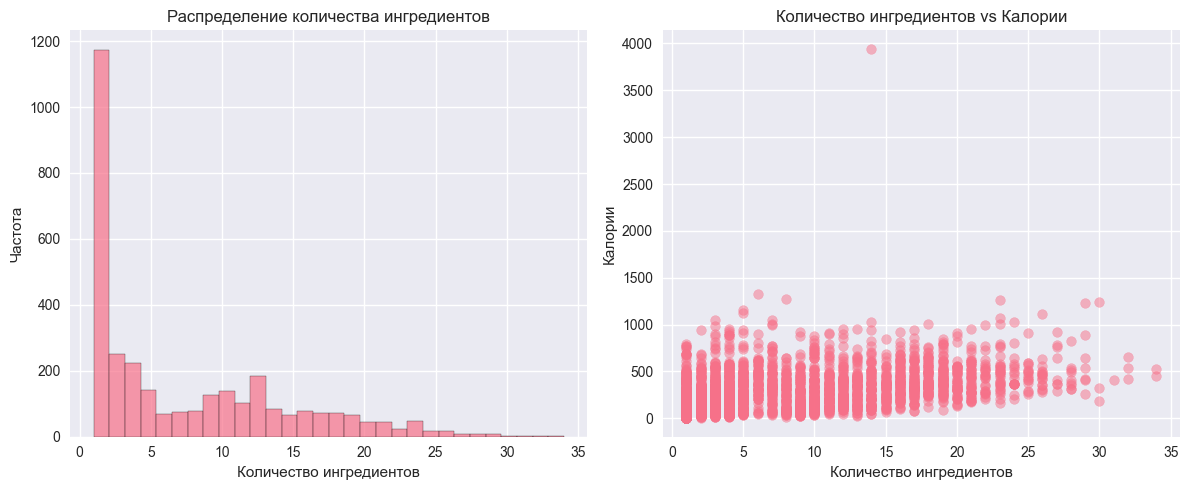

In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(dish_df['ingredient_count'], bins=30, alpha=0.7, edgecolor='black')
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤')
plt.xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤')
plt.ylabel('–ß–∞—Å—Ç–æ—Ç–∞')

plt.subplot(1, 2, 2)
plt.scatter(dish_df['ingredient_count'], dish_df['total_calories'], alpha=0.5)
plt.title('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤ vs –ö–∞–ª–æ—Ä–∏–∏')
plt.xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤')
plt.ylabel('–ö–∞–ª–æ—Ä–∏–∏')

plt.tight_layout()
plt.show()

–ê–Ω–∞–ª–∏–∑ —Å–∞–º—ã—Ö –ø–æ–ø—É–ª—è—Ä–Ω—ã—Ö –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤

In [25]:
print("\n=== –¢–û–ü-20 –°–ê–ú–´–• –ü–û–ü–£–õ–Ø–†–ù–´–• –ò–ù–ì–†–ï–î–ò–ï–ù–¢–û–í ===")
all_ingredients = []
for ingredients_str in dish_df['ingredients']:
    ingredients_list = ingredients_str.split(';')
    all_ingredients.extend(ingredients_list)

ingredient_counts = pd.Series(all_ingredients).value_counts()
top_ingredients = ingredient_counts.head(20)

print(top_ingredients)


=== –¢–û–ü-20 –°–ê–ú–´–• –ü–û–ü–£–õ–Ø–†–ù–´–• –ò–ù–ì–†–ï–î–ò–ï–ù–¢–û–í ===
ingr_0000000161    1561
ingr_0000000291    1379
ingr_0000000122     947
ingr_0000000312     723
ingr_0000000189     713
ingr_0000000094     686
ingr_0000000520     572
ingr_0000000515     506
ingr_0000000524     493
ingr_0000000471     481
ingr_0000000036     437
ingr_0000000045     432
ingr_0000000133     402
ingr_0000000027     398
ingr_0000000126     374
ingr_0000000031     329
ingr_0000000029     315
ingr_0000000028     306
ingr_0000000518     297
ingr_0000000514     296
Name: count, dtype: int64


In [26]:
ingredient_id_to_name = dict(zip(ingredients_df['id'].astype(str), ingredients_df['ingr']))

# –ü–µ—Ä–µ–≤–æ–¥–∏–º —Ç–æ–ø –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç—ã –≤ –Ω–∞–∑–≤–∞–Ω–∏—è
top_ingredient_names = []
for ingr_id in top_ingredients.index:
    ingr_id_clean = ingr_id.replace('ingr_', '').lstrip('0')
    if ingr_id_clean in ingredient_id_to_name:
        top_ingredient_names.append(ingredient_id_to_name[ingr_id_clean])
    else:
        top_ingredient_names.append(f"Unknown ({ingr_id})")

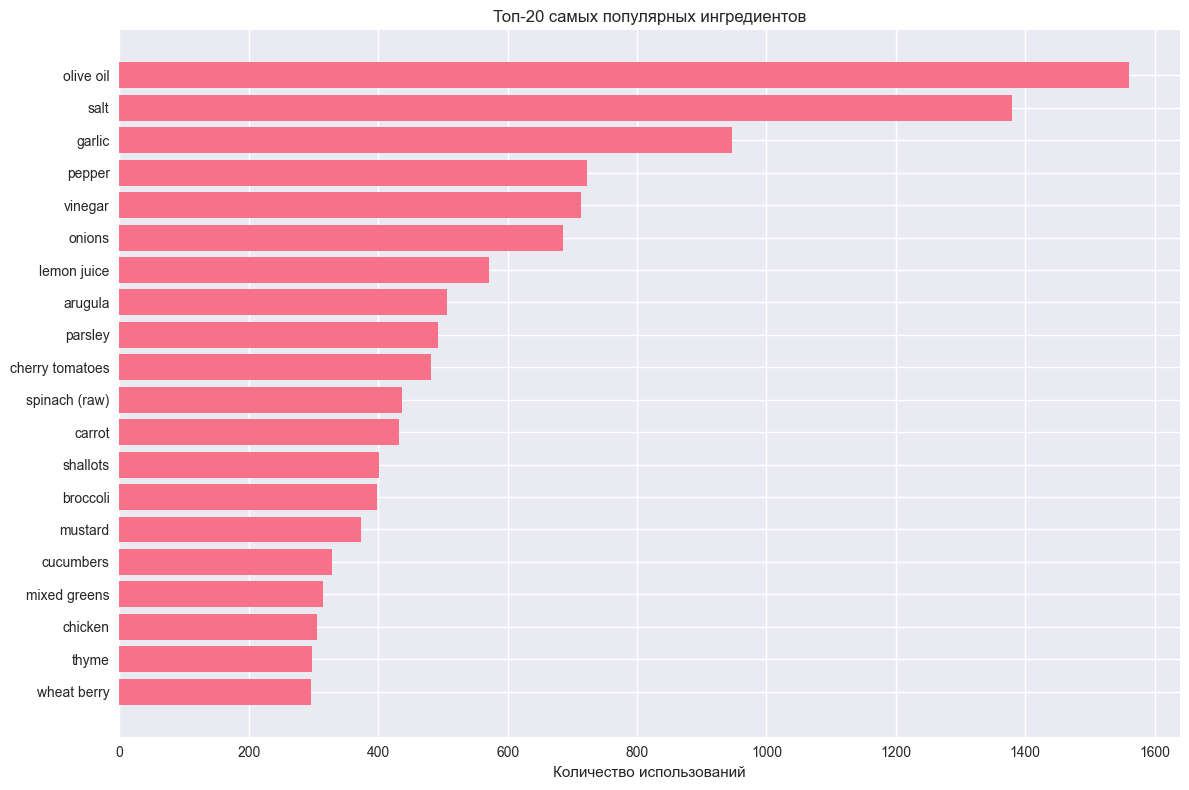

In [27]:
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_ingredient_names)), top_ingredients.values)
plt.yticks(range(len(top_ingredient_names)), top_ingredient_names)
plt.title('–¢–æ–ø-20 —Å–∞–º—ã—Ö –ø–æ–ø—É–ª—è—Ä–Ω—ã—Ö –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤')
plt.xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–π')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

–ê–Ω–∞–ª–∏–∑ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π

In [28]:
print("\n=== –ê–ù–ê–õ–ò–ó –ò–ó–û–ë–†–ê–ñ–ï–ù–ò–ô ===")
image_dir = 'data/images'
dish_ids_with_images = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞–ø–æ–∫ —Å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è–º–∏: {len(dish_ids_with_images)}")
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∑–∞–ø–∏—Å–µ–π –≤ dish.csv: {len(dish_df)}")


=== –ê–ù–ê–õ–ò–ó –ò–ó–û–ë–†–ê–ñ–ï–ù–ò–ô ===
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞–ø–æ–∫ —Å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è–º–∏: 3490
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∑–∞–ø–∏—Å–µ–π –≤ dish.csv: 3230


–ü—Ä–æ–≤–µ—Ä—è–µ–º —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–∏–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –∏ –¥–∞–Ω–Ω—ã—Ö

In [29]:
dish_ids_in_csv = set(dish_df['dish_id'].values)
dish_ids_with_images_set = set(dish_ids_with_images)
missing_images = dish_ids_in_csv - dish_ids_with_images_set
missing_data = dish_ids_with_images_set - dish_ids_in_csv

print(f"–ó–∞–ø–∏—Å–µ–π –±–µ–∑ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: {len(missing_images)}")
print(f"–ò–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –±–µ–∑ –∑–∞–ø–∏—Å–µ–π: {len(missing_data)}")

–ó–∞–ø–∏—Å–µ–π –±–µ–∑ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: 0
–ò–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –±–µ–∑ –∑–∞–ø–∏—Å–µ–π: 260


–í –ø–∞–ø–∫–µ data/images/ –µ—Å—Ç—å 228 –ø–∞–ø–æ–∫ —Å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è–º–∏, –¥–ª—è –∫–æ—Ç–æ—Ä—ã—Ö –Ω–µ—Ç —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–∏—Ö –∑–∞–ø–∏—Å–µ–π –≤ —Ñ–∞–π–ª–µ dish.csv.

In [30]:
missing_data = dish_ids_with_images_set - dish_ids_in_csv
print(f"–ü—Ä–∏–º–µ—Ä—ã –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –±–µ–∑ –∑–∞–ø–∏—Å–µ–π: {list(missing_data)[:10]}")

# –ü—Ä–æ–≤–µ—Ä–∏–º, –µ—Å—Ç—å –ª–∏ –∑–∞–∫–æ–Ω–æ–º–µ—Ä–Ω–æ—Å—Ç—å –≤ ID
missing_ids = [int(d.replace('dish_', '')) for d in missing_data]
print(f"–î–∏–∞–ø–∞–∑–æ–Ω ID –±–µ–∑ –∑–∞–ø–∏—Å–µ–π: {min(missing_ids)} - {max(missing_ids)}")

# –°—Ä–∞–≤–Ω–∏–º —Å —Å—É—â–µ—Å—Ç–≤—É—é—â–∏–º–∏ ID
existing_ids = [int(d.replace('dish_', '')) for d in dish_ids_in_csv]
print(f"–î–∏–∞–ø–∞–∑–æ–Ω —Å—É—â–µ—Å—Ç–≤—É—é—â–∏—Ö ID: {min(existing_ids)} - {max(existing_ids)}")

–ü—Ä–∏–º–µ—Ä—ã –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –±–µ–∑ –∑–∞–ø–∏—Å–µ–π: ['dish_1573156908', 'dish_1572291671', 'dish_1572453701', 'dish_1571935085', 'dish_1576100046', 'dish_1573579635', 'dish_1574455483', 'dish_1558030724', 'dish_1573156961', 'dish_1573073666']
–î–∏–∞–ø–∞–∑–æ–Ω ID –±–µ–∑ –∑–∞–ø–∏—Å–µ–π: 1556575700 - 1576259776
–î–∏–∞–ø–∞–∑–æ–Ω —Å—É—â–µ—Å—Ç–≤—É—é—â–∏—Ö ID: 1556572657 - 1568666357


–ü–æ—Ö–æ–∂–µ id —ç—Ç–æ Unix timestamp.

–°—É—â–µ—Å—Ç–≤—É—é—â–∏–µ –∑–∞–ø–∏—Å–∏ (–≤ CSV):
- –î–∏–∞–ø–∞–∑–æ–Ω: 1556572657 - 1568666357.
- –ü–µ—Ä–∏–æ–¥: –º–∞–π 2019 - —Å–µ–Ω—Ç—è–±—Ä—å 2019 (–ø—Ä–∏–º–µ—Ä–Ω–æ 4 –º–µ—Å—è—Ü–∞).


–ò–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è –±–µ–∑ –∑–∞–ø–∏—Å–µ–π:
- –î–∏–∞–ø–∞–∑–æ–Ω: 1571931457 - 1576259776.
- –ü–µ—Ä–∏–æ–¥: –æ–∫—Ç—è–±—Ä—å 2019 - –¥–µ–∫–∞–±—Ä—å 2019 (–ø—Ä–∏–º–µ—Ä–Ω–æ 2 –º–µ—Å—è—Ü–∞).

–í–æ–∑–º–æ–∂–Ω—ã–ø –ø—Ä–∏—á–∏–Ω—ã - –≤—Ä–µ–º–µ–Ω–Ω–æ–µ —Ä–∞–∑–¥–µ–ª–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö
- CSV —Å–æ–¥–µ—Ä–∂–∏—Ç –¥–∞–Ω–Ω—ã–µ –∑–∞ –ø–µ—Ä–≤—ã–π –ø–µ—Ä–∏–æ–¥ (–º–∞–π-—Å–µ–Ω—Ç—è–±—Ä—å 2019)
- –ò–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è –±–µ–∑ –∑–∞–ø–∏—Å–µ–π - —ç—Ç–æ –±–æ–ª–µ–µ –ø–æ–∑–¥–Ω–∏–µ –¥–∞–Ω–Ω—ã–µ (–æ–∫—Ç—è–±—Ä—å-–¥–µ–∫–∞–±—Ä—å 2019)

–ê–Ω–∞–ª–∏–∑ —Ä–∞–∑–º–µ—Ä–æ–≤ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π

–°—Ä–µ–¥–Ω–∏–π —Ä–∞–∑–º–µ—Ä –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è: 640x480
–ú–∏–Ω–∏–º–∞–ª—å–Ω—ã–π —Ä–∞–∑–º–µ—Ä: 640x480
–ú–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–π —Ä–∞–∑–º–µ—Ä: 640x480


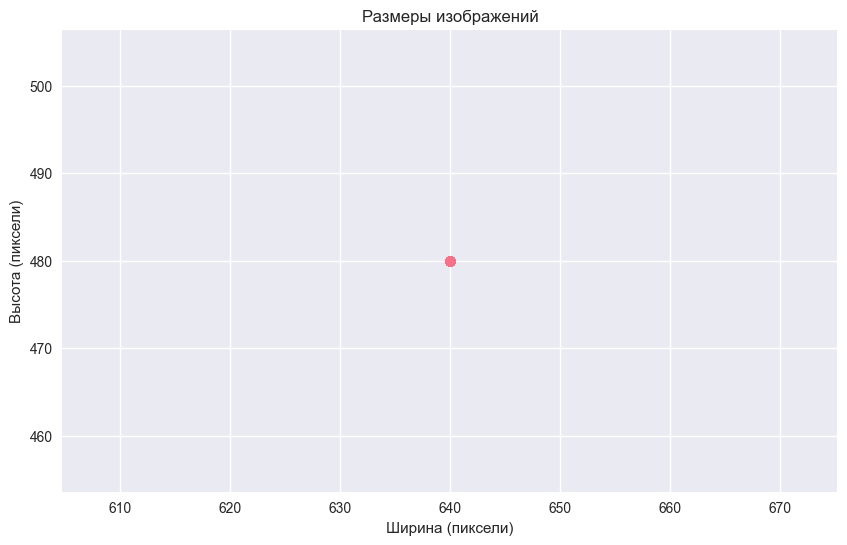

In [31]:
image_sizes = []
sample_images = dish_ids_with_images[:100]  # –ë–µ—Ä–µ–º –ø–µ—Ä–≤—ã–µ 100 –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞

for dish_id in sample_images:
    image_path = os.path.join(image_dir, dish_id, 'rgb.png')
    if os.path.exists(image_path):
        try:
            with Image.open(image_path) as img:
                image_sizes.append(img.size)
        except Exception as e:
            print(f"–û—à–∏–±–∫–∞ –ø—Ä–∏ –∑–∞–≥—Ä—É–∑–∫–µ {image_path}: {e}")

if image_sizes:
    widths, heights = zip(*image_sizes)
    print(f"–°—Ä–µ–¥–Ω–∏–π —Ä–∞–∑–º–µ—Ä –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è: {np.mean(widths):.0f}x{np.mean(heights):.0f}")
    print(f"–ú–∏–Ω–∏–º–∞–ª—å–Ω—ã–π —Ä–∞–∑–º–µ—Ä: {min(widths)}x{min(heights)}")
    print(f"–ú–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–π —Ä–∞–∑–º–µ—Ä: {max(widths)}x{max(heights)}")
    
    # –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–∞–∑–º–µ—Ä–æ–≤ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
    plt.figure(figsize=(10, 6))
    plt.scatter(widths, heights, alpha=0.6)
    plt.title('–†–∞–∑–º–µ—Ä—ã –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π')
    plt.xlabel('–®–∏—Ä–∏–Ω–∞ (–ø–∏–∫—Å–µ–ª–∏)')
    plt.ylabel('–í—ã—Å–æ—Ç–∞ (–ø–∏–∫—Å–µ–ª–∏)')
    plt.show()

–í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –ø—Ä–∏–º–µ—Ä–æ–≤ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π


=== –ü–†–ò–ú–ï–†–´ –ò–ó–û–ë–†–ê–ñ–ï–ù–ò–ô ===


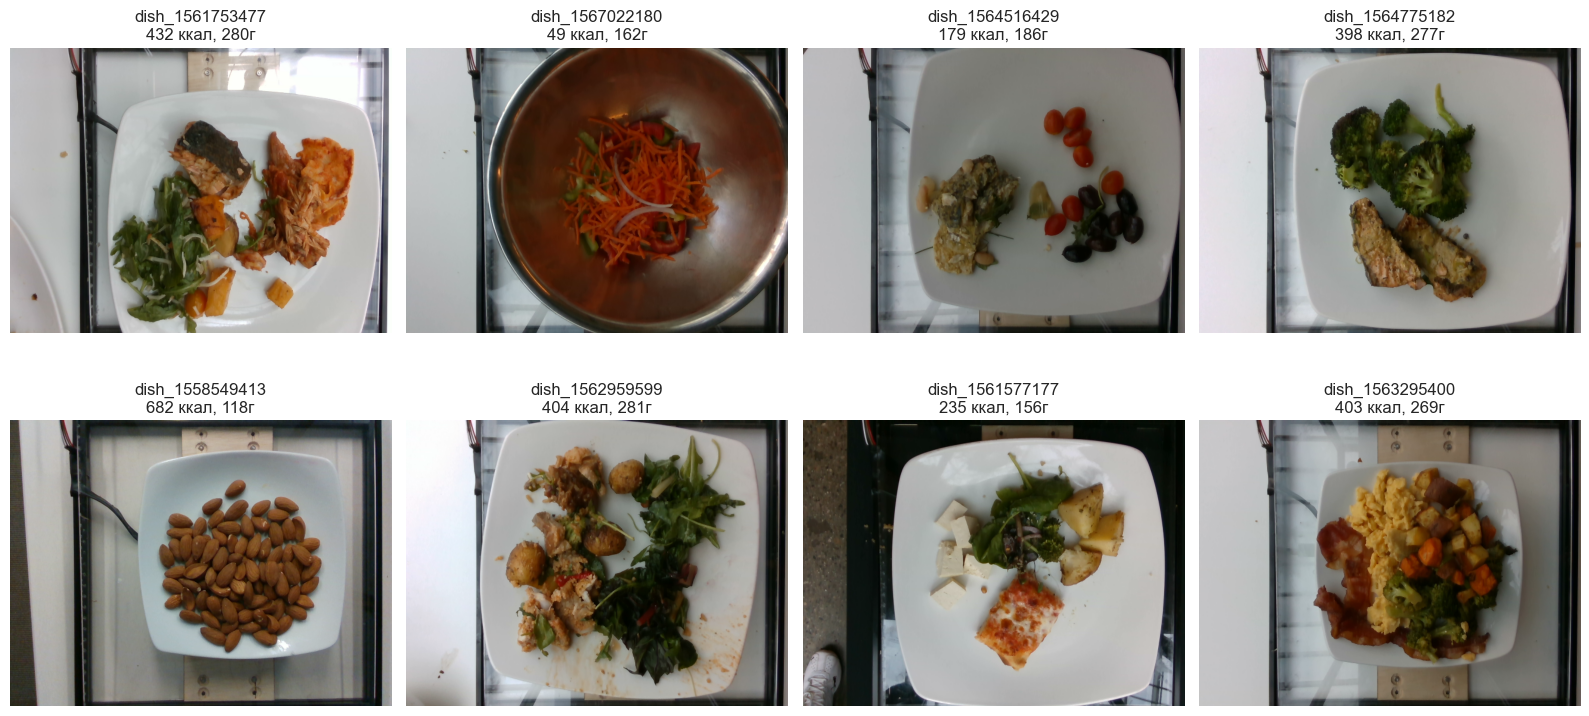

In [32]:
print("\n=== –ü–†–ò–ú–ï–†–´ –ò–ó–û–ë–†–ê–ñ–ï–ù–ò–ô ===")
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

sample_dishes = dish_df.sample(8)
for i, (_, dish) in enumerate(sample_dishes.iterrows()):
    image_path = os.path.join(image_dir, dish['dish_id'], 'rgb.png')
    if os.path.exists(image_path):
        try:
            with Image.open(image_path) as img:
                axes[i].imshow(img)
                axes[i].set_title(f"{dish['dish_id']}\n{dish['total_calories']:.0f} –∫–∫–∞–ª, {dish['total_mass']:.0f}–≥")
                axes[i].axis('off')
        except Exception as e:
            axes[i].text(0.5, 0.5, f"–û—à–∏–±–∫–∞ –∑–∞–≥—Ä—É–∑–∫–∏\n{e}", ha='center', va='center')
            axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, "–ò–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ –Ω–µ –Ω–∞–π–¥–µ–Ω–æ", ha='center', va='center')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

–ö–æ—Ä—Ä–µ–ª—è—Ü–∏–æ–Ω–Ω—ã–π –∞–Ω–∞–ª–∏–∑

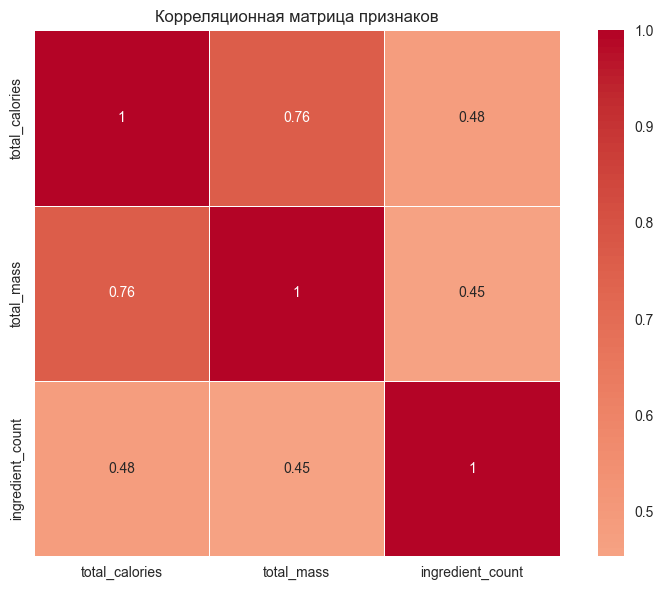

In [33]:
correlation_data = dish_df[['total_calories', 'total_mass', 'ingredient_count']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('–ö–æ—Ä—Ä–µ–ª—è—Ü–∏–æ–Ω–Ω–∞—è –º–∞—Ç—Ä–∏—Ü–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤')
plt.tight_layout()
plt.show()

–ê–Ω–∞–ª–∏–∑ –≤—ã–±—Ä–æ—Å–æ–≤

In [34]:
print("\n=== –ê–ù–ê–õ–ò–ó –í–´–ë–†–û–°–û–í ===")
Q1_calories = dish_df['total_calories'].quantile(0.25)
Q3_calories = dish_df['total_calories'].quantile(0.75)
IQR_calories = Q3_calories - Q1_calories
outliers_calories = dish_df[(dish_df['total_calories'] < Q1_calories - 1.5*IQR_calories) | 
                           (dish_df['total_calories'] > Q3_calories + 1.5*IQR_calories)]
print(f"–í—ã–±—Ä–æ—Å—ã –ø–æ –∫–∞–ª–æ—Ä–∏—è–º: {len(outliers_calories)} ({len(outliers_calories)/len(dish_df)*100:.1f}%)")

Q1_mass = dish_df['total_mass'].quantile(0.25)
Q3_mass = dish_df['total_mass'].quantile(0.75)
IQR_mass = Q3_mass - Q1_mass
outliers_mass = dish_df[(dish_df['total_mass'] < Q1_mass - 1.5*IQR_mass) | 
                       (dish_df['total_mass'] > Q3_mass + 1.5*IQR_mass)]
print(f"–í—ã–±—Ä–æ—Å—ã –ø–æ –º–∞—Å—Å–µ: {len(outliers_mass)} ({len(outliers_mass)/len(dish_df)*100:.1f}%)")


=== –ê–ù–ê–õ–ò–ó –í–´–ë–†–û–°–û–í ===
–í—ã–±—Ä–æ—Å—ã –ø–æ –∫–∞–ª–æ—Ä–∏—è–º: 58 (1.8%)
–í—ã–±—Ä–æ—Å—ã –ø–æ –º–∞—Å—Å–µ: 57 (1.8%)


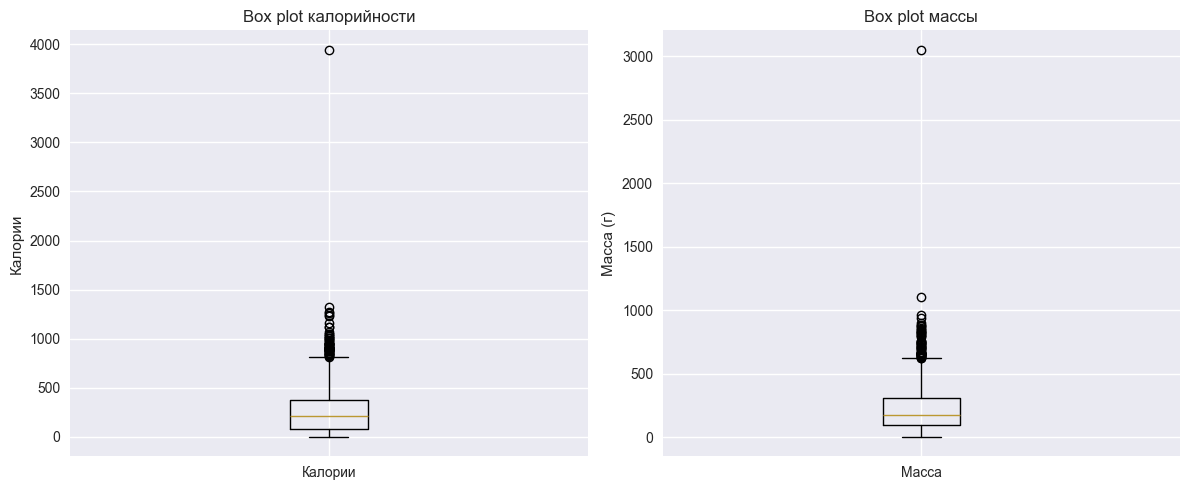

In [35]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.boxplot([dish_df['total_calories']], labels=['–ö–∞–ª–æ—Ä–∏–∏'])
plt.title('Box plot –∫–∞–ª–æ—Ä–∏–π–Ω–æ—Å—Ç–∏')
plt.ylabel('–ö–∞–ª–æ—Ä–∏–∏')

plt.subplot(1, 2, 2)
plt.boxplot([dish_df['total_mass']], labels=['–ú–∞—Å—Å–∞'])
plt.title('Box plot –º–∞—Å—Å—ã')
plt.ylabel('–ú–∞—Å—Å–∞ (–≥)')

plt.tight_layout()
plt.show()

## –í—ã–≤–æ–¥—ã –ø–æ EDA

### –í—ã–≤–æ–¥—ã –ø–æ –∏—Å—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å—Å–∫–æ–º—É –∞–Ω–∞–ª–∏–∑—É –¥–∞–Ω–Ω—ã—Ö (EDA)

**–û–±—â–∞—è —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∞ –¥–∞—Ç–∞—Å–µ—Ç–∞:**
- –û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –±–ª—é–¥: **3,262 –∑–∞–ø–∏—Å–∏**
- –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤: **555 –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤**
- –†–∞–∑–º–µ—Ä –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: 480 –Ω–∞ 640 standard RGBA –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è (–∫–∞–∂–¥–æ–µ –±–ª—é–¥–æ –∏–º–µ–µ—Ç —Å–≤–æ—é –ø–∞–ø–∫—É —Å —Ñ–∞–π–ª–æ–º rgb.png)
- –ü—Ä–æ–ø—É—Å–∫–æ–≤ –≤ –¥–∞–Ω–Ω—ã—Ö –Ω–µ—Ç

**–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö –ø–æ —Å–ø–ª–∏—Ç–∞–º:**
- Train/Test —Ä–∞–∑–¥–µ–ª–µ–Ω–∏–µ —É–∂–µ –ø—Ä–æ–≤–µ–¥–µ–Ω–æ –≤ –∫–æ–ª–æ–Ω–∫–µ 'split'

**–û—Å–æ–±–µ–Ω–Ω–æ—Å—Ç–∏ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π:**
- –ö–∞–ª–æ—Ä–∏–π–Ω–æ—Å—Ç—å –±–ª—é–¥ –≤–∞—Ä—å–∏—Ä—É–µ—Ç—Å—è –æ—Ç –æ—á–µ–Ω—å –Ω–∏–∑–∫–∏—Ö –∑–Ω–∞—á–µ–Ω–∏–π (–Ω–µ—Å–∫–æ–ª—å–∫–æ –∫–∫–∞–ª) –¥–æ –≤—ã—Å–æ–∫–∏—Ö (–±–æ–ª–µ–µ 1000 –∫–∫–∞–ª)
- –ë–æ–ª—å—à–∏–Ω—Å—Ç–≤–æ –±–ª—é–¥ –∏–º–µ—é—Ç –∫–∞–ª–æ—Ä–∏–π–Ω–æ—Å—Ç—å –≤ —Ä–∞–∑—É–º–Ω–æ–º –¥–∏–∞–ø–∞–∑–æ–Ω–µ –¥–ª—è –ø–æ—Ä—Ü–∏–æ–Ω–Ω—ã—Ö –±–ª—é–¥
- –¶–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è (total_calories) –Ω–µ–ø—Ä–µ—Ä—ã–≤–Ω–∞—è - —ç—Ç–æ –∑–∞–¥–∞—á–∞ —Ä–µ–≥—Ä–µ—Å—Å–∏–∏

**–ú—É–ª—å—Ç–∏–º–æ–¥–∞–ª—å–Ω–æ—Å—Ç—å –¥–∞–Ω–Ω—ã—Ö:**
- **–í–∏–∑—É–∞–ª—å–Ω–∞—è –º–æ–¥–∞–ª—å–Ω–æ—Å—Ç—å**: RGB –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è –±–ª—é–¥ –Ω–∞ —Ç–∞—Ä–µ–ª–∫–∞—Ö, —Å—Ç–∞–Ω–¥–∞—Ä—Ç–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω—ã–π —Ñ–æ—Ä–º–∞—Ç
- **–¢–µ–∫—Å—Ç–æ–≤–∞—è –º–æ–¥–∞–ª—å–Ω–æ—Å—Ç—å**: —Å–ø–∏—Å–æ–∫ ID –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤ –≤ —Ñ–æ—Ä–º–∞—Ç–µ "ingr_0000000508;ingr_0000000122;..."
- **–î–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω–∞—è –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è**: –º–∞—Å—Å–∞ –ø–æ—Ä—Ü–∏–∏ (total_mass) –¥–ª—è –ø–æ—Ç–µ–Ω—Ü–∏–∞–ª—å–Ω–æ–≥–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è

**–û—Å–æ–±–µ–Ω–Ω–æ—Å—Ç–∏ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤:**
- –ò–Ω—Ç–µ—Ä–µ—Å–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤ –æ—Ç –±–∞–∑–æ–≤—ã—Ö –ø—Ä–æ–¥—É–∫—Ç–æ–≤ –¥–æ –≥–æ—Ç–æ–≤—ã—Ö –±–ª—é–¥ –∏ —Å–æ—É—Å–æ–≤
- –ú–Ω–æ–≥–∏–µ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç—ã –ø—Ä–µ–¥—Å—Ç–∞–≤–ª—è—é—Ç —Å–æ–±–æ–π –≥–æ—Ç–æ–≤—ã–µ –±–ª—é–¥–∞ (–Ω–∞–ø—Ä–∏–º–µ—Ä, "caesar salad", "pasta"), —á—Ç–æ —É—Å–ª–æ–∂–Ω—è–µ—Ç –∑–∞–¥–∞—á—É
- –ù–µ–∫–æ—Ç–æ—Ä—ã–µ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç—ã –ø–æ–º–µ—á–µ–Ω—ã –∫–∞–∫ "deprecated", —á—Ç–æ —É–∫–∞–∑—ã–≤–∞–µ—Ç –Ω–∞ —ç–≤–æ–ª—é—Ü–∏—é –¥–∞—Ç–∞—Å–µ—Ç–∞

**–í—ã–∑–æ–≤—ã –∏ –æ—Å–æ–±–µ–Ω–Ω–æ—Å—Ç–∏:**
1. –†–∞–∑–ª–∏—á–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤ –≤ –±–ª—é–¥–∞—Ö (–æ—Ç 1 –¥–æ –º–Ω–æ–≥–∏—Ö)
2. –ù–µ—Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–∞—è —Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏—è –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤ —á–µ—Ä–µ–∑ ID –≤–º–µ—Å—Ç–æ –Ω–∞–∑–≤–∞–Ω–∏–π
3. –í—ã—Å–æ–∫–∞—è –≤–∞—Ä–∏–∞—Ç–∏–≤–Ω–æ—Å—Ç—å –∫–∞–ª–æ—Ä–∏–π–Ω–æ—Å—Ç–∏ - –ø–æ—Ç—Ä–µ–±—É–µ—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω–∞—è –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è
4. –ö–æ–º–±–∏–Ω–∞—Ü–∏—è –≤–∏–∑—É–∞–ª—å–Ω–æ–π –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –±–ª—é–¥–∞ —Å —Å–æ—Å—Ç–∞–≤–æ–º –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤ —Ç—Ä–µ–±—É–µ—Ç –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ–≥–æ –º—É–ª—å—Ç–∏–º–æ–¥–∞–ª—å–Ω–æ–≥–æ –ø–æ–¥—Ö–æ–¥–∞

## –í–∏–¥–µ–Ω–∏–µ —Ä–µ—à–µ–Ω–∏—è

### –í–∏–¥–µ–Ω–∏–µ —Ä–µ—à–µ–Ω–∏—è –∑–∞–¥–∞—á–∏ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –∫–∞–ª–æ—Ä–∏–π–Ω–æ—Å—Ç–∏ –±–ª—é–¥

**–û–±—â–∏–π –ø–æ–¥—Ö–æ–¥:**
–†–µ—à–∞–µ–º –º—É–ª—å—Ç–∏–º–æ–¥–∞–ª—å–Ω—É—é –∑–∞–¥–∞—á—É —Ä–µ–≥—Ä–µ—Å—Å–∏–∏ —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—ã —Å –¥–≤—É–º—è –ø–∞—Ä–∞–ª–ª–µ–ª—å–Ω—ã–º–∏ —ç–Ω–∫–æ–¥–µ—Ä–∞–º–∏ - –¥–ª—è –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –∏ —Ç–µ–∫—Å—Ç–∞ (–∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤), —Å –ø–æ—Å–ª–µ–¥—É—é—â–∏–º —Å–ª–∏—è–Ω–∏–µ–º –∏ —Ñ–∏–Ω–∞–ª—å–Ω—ã–º —Ä–µ–≥—Ä–µ—Å—Å–æ—Ä–æ–º.

**–ê—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞ —Ä–µ—à–µ–Ω–∏—è:**

1. **–ú—É–ª—å—Ç–∏–º–æ–¥–∞–ª—å–Ω–∞—è –º–æ–¥–µ–ª—å:**
   - Vision Encoder: EfficientNet-B3 (—Ö–æ—Ä–æ—à–∏–π –±–∞–ª–∞–Ω—Å —Ç–æ—á–Ω–æ—Å—Ç–∏/—Å–∫–æ—Ä–æ—Å—Ç–∏) –¥–ª—è –æ–±—Ä–∞–±–æ—Ç–∫–∏ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –±–ª—é–¥
   - Text Encoder: DistilBERT –¥–ª—è –æ–±—Ä–∞–±–æ—Ç–∫–∏ —Å–ø–∏—Å–∫–∞ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤
   - Fusion Layer: Concatenation + MLP –¥–ª—è –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏—è –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
   - Regression Head: MLP –¥–ª—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –∫–∞–ª–æ—Ä–∏–π–Ω–æ—Å—Ç–∏

2. **–û–±—Ä–∞–±–æ—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö:**
   - –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ ID –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤ –≤ —Ç–µ–∫—Å—Ç–æ–≤–æ–µ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏–µ ("ingr_001;ingr_002" ‚Üí "potato;rice;chicken")
   - –ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –ø–æ–¥ —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω—ã–µ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è –¥–ª—è EfficientNet
   - –ò—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ –º–∞—Å—Å—ã –ø–æ—Ä—Ü–∏–∏ –∫–∞–∫ –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω–æ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–∞ –¥–ª—è –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–∏ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π
   - –†–µ—à–µ–Ω–∏–µ –ø—Ä–æ–±–ª–µ–º—ã –æ—Ç—Å—É—Ç—Å—Ç–≤—É—é—â–∏—Ö –¥–∞–Ω–Ω—ã—Ö: –ò—Å–∫–ª—é—á–µ–Ω–∏–µ 259 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –±–µ–∑ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–∏—Ö –∑–∞–ø–∏—Å–µ–π –≤ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–µ

3) **–†–∞–±–æ—Ç–∞ —Å –Ω–µ–ø–æ–ª–Ω—ã–º–∏ –¥–∞–Ω–Ω—ã–º–∏:**
   - –°–∏–Ω—Ö—Ä–æ–Ω–∏–∑–∞—Ü–∏—è —Ñ–∞–π–ª–æ–≤–æ–π —Å–∏—Å—Ç–µ–º—ã —Å —Ç–∞–±–ª–∏—á–Ω—ã–º–∏ –¥–∞–Ω–Ω—ã–º–∏
   - –ü—Ä–æ–≤–µ—Ä–∫–∞ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–∏—è –Ω–∞–ª–∏—á–∏—è –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –∑–∞–ø–∏—Å—è–º –≤ dish.csv
   - –§–∏–ª—å—Ç—Ä–∞—Ü–∏—è –¥–∞—Ç–∞—Å–µ—Ç–∞ —Ç–æ–ª—å–∫–æ –ø–æ –∑–∞–ø–∏—Å—è–º —Å –ø–æ–ª–Ω—ã–º–∏ –¥–∞–Ω–Ω—ã–º–∏ (–∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ + –º–µ—Ç–∞–¥–∞–Ω–Ω—ã–µ)
   - –§—É–Ω–∫—Ü–∏—è –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —Ü–µ–ª–æ—Å—Ç–Ω–æ—Å—Ç–∏ –¥–∞–Ω–Ω—ã—Ö –ø–µ—Ä–µ–¥ –æ–±—É—á–µ–Ω–∏–µ–º

**–ü–æ–¥—Ö–æ–¥—ã –∫ –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏ –∏ –æ–±–æ–≥–∞—â–µ–Ω–∏—é –¥–∞–Ω–Ω—ã—Ö:**

1. **–ê—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π:**
   - Standard augmentations: –≥–æ—Ä–∏–∑–æ–Ω—Ç–∞–ª—å–Ω—ã–π —Ñ–ª–∏–ø, –ø–æ–≤–æ—Ä–æ—Ç, –∏–∑–º–µ–Ω–µ–Ω–∏–µ —è—Ä–∫–æ—Å—Ç–∏/–∫–æ–Ω—Ç—Ä–∞—Å—Ç–∞
   - –ü–æ—Å–∫–æ–ª—å–∫—É —ç—Ç–æ —Ñ–æ—Ç–æ–≥—Ä–∞—Ñ–∏–∏ –µ–¥—ã, —Å–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∞–ª–∏—Å—Ç–∏—á–Ω–æ—Å—Ç—å
   - Random Crop + Resize –¥–ª—è –∏–∑–º–µ–Ω–µ–Ω–∏—è –∫–æ–º–ø–æ–∑–∏—Ü–∏–∏ –∫–∞–¥—Ä–∞
   - ColorJitter –¥–ª—è —Ä–∞–∑–Ω–æ–æ–±—Ä–∞–∑–∏—è –æ—Å–≤–µ—â–µ–Ω–∏—è

2. **–ê—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏ —Ç–µ–∫—Å—Ç–∞:**
   - –°–∏–Ω—Ö—Ä–æ–Ω–∏–∑–∞—Ü–∏—è –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–π –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π —Å —Ç–µ–∫—Å—Ç–æ–º –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤

3. **–û–±–æ–≥–∞—â–µ–Ω–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤:**
   - –ò—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ –º–∞—Å—Å—ã –ø–æ—Ä—Ü–∏–∏ –¥–ª—è —Ä–∞—Å—á–µ—Ç–∞ –∫–∞–ª–æ—Ä–∏–π –Ω–∞ –µ–¥–∏–Ω–∏—Ü—É –º–∞—Å—Å—ã
   - –°–æ–∑–¥–∞–Ω–∏–µ –Ω–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤, –∫–∞—Ç–µ–≥–æ—Ä–∏–∏ –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤

**–ú–µ—Ç—Ä–∏–∫–∏ –∏ –∫—Ä–∏—Ç–µ—Ä–∏–∏ –æ—Ü–µ–Ω–∫–∏:**

1. **–û—Å–Ω–æ–≤–Ω–æ–µ –º–µ—Ç—Ä–∏–∫–∏:**
   - **MAE (Mean Absolute Error)** - –≥–ª–∞–≤–Ω–∞—è –º–µ—Ç—Ä–∏–∫–∞, —Ü–µ–ª—å < 50 –∫–∫–∞–ª
   - **MSE** –¥–ª—è —Ä–∞–Ω–Ω–µ–≥–æ –≤—ã—è–≤–ª–µ–Ω–∏—è –≤—ã–±—Ä–æ—Å–æ–≤
   - **MAPE (Mean Absolute Percentage Error)** –¥–ª—è –æ—Ü–µ–Ω–∫–∏ –≤ –ø—Ä–æ—Ü–µ–Ω—Ç–∞—Ö

2. **–°—Ç—Ä–∞—Ç–µ–≥–∏—è –≤–∞–ª–∏–¥–∞—Ü–∏–∏:**
   - Stratified splitting –ø–æ –¥–∏–∞–ø–∞–∑–æ–Ω–∞–º –∫–∞–ª–æ—Ä–∏–π–Ω–æ—Å—Ç–∏ –¥–ª—è —Ä–∞–≤–Ω–æ–º–µ—Ä–Ω–æ–≥–æ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏—è
   - Early stopping –ø–æ MAE –Ω–∞ validation set
   - –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ –ø–æ –º–µ—Ç—Ä–∏–∫–µ MAE
   - –ü–µ—Ä–µ—Å—á–µ—Ç —Ä–∞–∑–º–µ—Ä–æ–≤ –¥–∞—Ç–∞—Å–µ—Ç–∞ –ø–æ—Å–ª–µ —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏ –Ω–µ–ø–æ–ª–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö

3. **–°—Ç—Ä–∞—Ç–µ–≥–∏—è –æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–∏:**
   - Loss —Ñ—É–Ω–∫—Ü–∏—è: –ò—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ Huber Loss (Smooth L1) –≤–º–µ—Å—Ç–æ –∫–ª–∞—Å—Å–∏—á–µ—Å–∫–æ–≥–æ MSE –¥–ª—è –±–æ–ª—å—à–µ–π —É—Å—Ç–æ–π—á–∏–≤–æ—Å—Ç–∏ –∫ –≤—ã–±—Ä–æ—Å–∞–º –≤ –∫–∞–ª–æ—Ä–∏–π–Ω–æ—Å—Ç–∏
   - –ü–æ—ç—Ç–∞–ø–Ω–æ–µ –æ–±—É—á–µ–Ω–∏–µ: –°–Ω–∞—á–∞–ª–∞ –∑–∞–º–æ—Ä–æ–∑–∫–∞ –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω—ã—Ö —ç–Ω–∫–æ–¥–µ—Ä–æ–≤ (1-2 —ç–ø–æ—Ö–∏), –∑–∞—Ç–µ–º —Ä–∞–∑–º–æ—Ä–æ–∑–∫–∞ –∏ –¥–æ–æ–±—É—á–µ–Ω–∏–µ –≤—Å–µ–π —Å–µ—Ç–∏
   - –î–∏—Ñ—Ñ–µ—Ä–µ–Ω—Ü–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ —Å–∫–æ—Ä–æ—Å—Ç–∏ –æ–±—É—á–µ–Ω–∏—è: –†–∞–∑–Ω—ã–µ learning rates –¥–ª—è —Ä–∞–∑–Ω—ã—Ö –∫–æ–º–ø–æ–Ω–µ–Ω—Ç–æ–≤:
     - Vision encoder: 1e-5 (–º–µ–¥–ª–µ–Ω–Ω–æ–µ –¥–æ–æ–±—É—á–µ–Ω–∏–µ)
     - Text encoder: 1e-5 (–º–µ–¥–ª–µ–Ω–Ω–æ–µ –¥–æ–æ–±—É—á–µ–Ω–∏–µ) 
     - Fusion layers: 1e-4 (–±—ã—Å—Ç—Ä–æ–µ –æ–±—É—á–µ–Ω–∏–µ –Ω–æ–≤—ã—Ö —Å–ª–æ–µ–≤)

# –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏

In [36]:
# –î–æ–±–∞–≤–ª—è–µ–º –ø–∞–ø–∫—É scripts –≤ –ø—É—Ç—å –¥–ª—è –∏–º–ø–æ—Ä—Ç–∞ –º–æ–¥—É–ª–µ–π
root_path = Path().cwd()
sys.path.append(str(root_path / "scripts"))

# –ü—Ä–æ–≤–µ—Ä—è–µ–º –¥–æ—Å—Ç—É–ø–Ω–æ—Å—Ç—å GPU
print(f"PyTorch –≤–µ—Ä—Å–∏—è: {torch.__version__}")
print(f"CUDA –¥–æ—Å—Ç—É–ø–Ω–∞: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU —É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ: {torch.cuda.get_device_name(0)}")
    print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ GPU: {torch.cuda.device_count()}")
    device = torch.device('cuda')
else:
    print("–ò—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è CPU")
    device = torch.device('cpu')

print(f"–í—ã–±—Ä–∞–Ω–Ω–æ–µ —É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ: {device}")

PyTorch –≤–µ—Ä—Å–∏—è: 2.5.1+cu124
CUDA –¥–æ—Å—Ç—É–ø–Ω–∞: True
GPU —É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ: NVIDIA GeForce RTX 3070
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ GPU: 1
–í—ã–±—Ä–∞–Ω–Ω–æ–µ —É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ: cuda


In [37]:
# –ó–∞–≥—Ä—É–∑–∫–∞ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏
config_path = "configs/config.yaml"

with open(config_path, 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

print("–ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è –∑–∞–≥—Ä—É–∂–µ–Ω–∞:")
print(f"–ú–æ–¥–µ–ª—å –¥–ª—è –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: {config['vision_model']}")
print(f"–ú–æ–¥–µ–ª—å –¥–ª—è —Ç–µ–∫—Å—Ç–∞: {config['text_model']}")
print(f"–†–∞–∑–º–µ—Ä –±–∞—Ç—á–∞: {config['batch_size']}")
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —ç–ø–æ—Ö: {config['epochs']}")
print(f"Hidden dimension: {config['hidden_dim']}")
print(f"Target MAE: {config['target_mae']} –∫–∫–∞–ª")

–ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è –∑–∞–≥—Ä—É–∂–µ–Ω–∞:
–ú–æ–¥–µ–ª—å –¥–ª—è –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: efficientnet_b3
–ú–æ–¥–µ–ª—å –¥–ª—è —Ç–µ–∫—Å—Ç–∞: bert-base-uncased
–†–∞–∑–º–µ—Ä –±–∞—Ç—á–∞: 12
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —ç–ø–æ—Ö: 50
Hidden dimension: 768
Target MAE: 50 –∫–∫–∞–ª


In [38]:
# –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –æ–±—É—á–µ–Ω–∏—è

print("–ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö...")
dish_df = pd.read_csv('data/dish.csv')
ingredients_df = pd.read_csv('data/ingredients.csv')

print(f"–í—Å–µ–≥–æ –±–ª—é–¥: {len(dish_df)}")
print(f"–¢—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã—Ö: {len(dish_df[dish_df['split'] == 'train'])}")
print(f"–¢–µ—Å—Ç–æ–≤—ã—Ö: {len(dish_df[dish_df['split'] == 'test'])}")
print(f"–£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤: {len(ingredients_df)}")

# –°–æ–∑–¥–∞–Ω–∏–µ –∑–∞–≥—Ä—É–∑—á–∏–∫–æ–≤ –¥–∞–Ω–Ω—ã—Ö
train_loader, val_loader = create_data_loaders(
    dish_df=dish_df,
    ingredients_df=ingredients_df,
    image_dir='data/images',
    batch_size=config['batch_size'],
    num_workers=config['num_workers']
)

print(f"–†–∞–∑–º–µ—Ä train –±–∞—Ç—á–∞: {len(train_loader.dataset)}")
print(f"–†–∞–∑–º–µ—Ä val –±–∞—Ç—á–∞: {len(val_loader.dataset)}")
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ train –∏—Ç–µ—Ä–∞—Ü–∏–π: {len(train_loader)}")
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ val –∏—Ç–µ—Ä–∞—Ü–∏–π: {len(val_loader)}")

–ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö...
–í—Å–µ–≥–æ –±–ª—é–¥: 3262
–¢—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã—Ö: 2755
–¢–µ—Å—Ç–æ–≤—ã—Ö: 507
–£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–≤: 555
üìê –û–ø—Ç–∏–º–∞–ª—å–Ω–æ–µ —Ä–∞–∑—Ä–µ—à–µ–Ω–∏–µ –¥–ª—è EfficientNet-B3: 288
–ó–∞–≥—Ä—É–∂–µ–Ω–æ 2755 –æ–±—Ä–∞–∑—Ü–æ–≤ –¥–ª—è —Ä–µ–∂–∏–º–∞ train
üìê –û–ø—Ç–∏–º–∞–ª—å–Ω–æ–µ —Ä–∞–∑—Ä–µ—à–µ–Ω–∏–µ –¥–ª—è EfficientNet-B3: 288
–ó–∞–≥—Ä—É–∂–µ–Ω–æ 507 –æ–±—Ä–∞–∑—Ü–æ–≤ –¥–ª—è —Ä–µ–∂–∏–º–∞ test
–†–∞–∑–º–µ—Ä train –±–∞—Ç—á–∞: 2755
–†–∞–∑–º–µ—Ä val –±–∞—Ç—á–∞: 507
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ train –∏—Ç–µ—Ä–∞—Ü–∏–π: 230
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ val –∏—Ç–µ—Ä–∞—Ü–∏–π: 43


In [39]:
# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –º–æ–¥–µ–ª–∏
print("–ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –º–æ–¥–µ–ª–∏...")

# –£—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º seed –¥–ª—è –≤–æ—Å–ø—Ä–æ–∏–∑–≤–æ–¥–∏–º–æ—Å—Ç–∏
seed_everything(config['seed'])

# –°–æ–∑–¥–∞–µ–º –º–æ–¥–µ–ª—å
model = CaloriePredictor(
    vision_model_name=config['vision_model'],
    text_model_name=config['text_model'],
    hidden_dim=config['hidden_dim'],
    dropout_rate=config['dropout_rate']
)

# –ü–µ—Ä–µ–º–µ—â–∞–µ–º –º–æ–¥–µ–ª—å –Ω–∞ —É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ
model = model.to(device)

# –ü–µ—á–∞—Ç–∞–µ–º –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é –æ –º–æ–¥–µ–ª–∏
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"–û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤: {total_params:,}")
print(f"–û–±—É—á–∞–µ–º—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤: {trainable_params:,}")
print(f"–ú–æ–¥–µ–ª—å –ø–µ—Ä–µ–º–µ—â–µ–Ω–∞ –Ω–∞ —É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ: {device}")

# –ü—Ä–æ–≤–µ—Ä—è–µ–º –¥–æ—Å—Ç—É–ø–Ω–æ—Å—Ç—å –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π
print("\n–ü—Ä–æ–≤–µ—Ä–∫–∞ –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π:")
try:
    print(f"‚úì EfficientNet-B3 –¥–æ—Å—Ç—É–ø–µ–Ω: {config['vision_model'] in timm.list_models()}")
except:
    print("‚úó –ü—Ä–æ–±–ª–µ–º–∞ —Å timm")

try:
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained(config['text_model'])
    print(f"‚úì DistilBERT –¥–æ—Å—Ç—É–ø–µ–Ω: {config['text_model']}")
except:
    print("‚úó –ü—Ä–æ–±–ª–µ–º–∞ —Å transformers")

–ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –º–æ–¥–µ–ª–∏...
–û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤: 124,632,169
–û–±—É—á–∞–µ–º—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤: 124,632,169
–ú–æ–¥–µ–ª—å –ø–µ—Ä–µ–º–µ—â–µ–Ω–∞ –Ω–∞ —É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ: cuda

–ü—Ä–æ–≤–µ—Ä–∫–∞ –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π:
‚úì EfficientNet-B3 –¥–æ—Å—Ç—É–ø–µ–Ω: True
‚úì DistilBERT –¥–æ—Å—Ç—É–ø–µ–Ω: bert-base-uncased


In [40]:
# –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–∞ –∏ –ø–ª–∞–Ω–∏—Ä–æ–≤—â–∏–∫–∞
print("–ù–∞—Å—Ç—Ä–æ–π–∫–∞ –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–∞...")

optimizer, scheduler = create_optimizer_and_scheduler(model, config)

print("–ü–∞—Ä–∞–º–µ—Ç—Ä—ã –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–∞:")
for i, group in enumerate(optimizer.param_groups):
    print(f"  –ì—Ä—É–ø–ø–∞ {i}: LR={group['lr']:.2e}, Params={group['name']}")

# –§—É–Ω–∫—Ü–∏—è –ø–æ—Ç–µ—Ä—å
criterion = torch.nn.SmoothL1Loss(reduction='mean')
print(f"–§—É–Ω–∫—Ü–∏—è –ø–æ—Ç–µ—Ä—å: SmoothL1Loss")

# –°–æ–∑–¥–∞–µ–º –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏—é –¥–ª—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è –º–æ–¥–µ–ª–∏
os.makedirs(config['output_dir'], exist_ok=True)
print(f"–î–∏—Ä–µ–∫—Ç–æ—Ä–∏—è –¥–ª—è –º–æ–¥–µ–ª–∏: {config['output_dir']}")

–ù–∞—Å—Ç—Ä–æ–π–∫–∞ –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–∞...
–ü–∞—Ä–∞–º–µ—Ç—Ä—ã –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–∞:
  –ì—Ä—É–ø–ø–∞ 0: LR=4.00e-06, Params=vision
  –ì—Ä—É–ø–ø–∞ 1: LR=4.00e-06, Params=text
  –ì—Ä—É–ø–ø–∞ 2: LR=1.00e-04, Params=fusion
–§—É–Ω–∫—Ü–∏—è –ø–æ—Ç–µ—Ä—å: SmoothL1Loss
–î–∏—Ä–µ–∫—Ç–æ—Ä–∏—è –¥–ª—è –º–æ–¥–µ–ª–∏: models


In [41]:
# –¢–µ—Å—Ç–æ–≤–∞—è –ø—Ä–æ–≤–µ—Ä–∫–∞ –æ–¥–Ω–æ–≥–æ –±–∞—Ç—á–∞
print("–ü—Ä–æ–≤–µ—Ä–∫–∞ –æ–¥–Ω–æ–≥–æ –±–∞—Ç—á–∞...")

# –ü–µ—Ä–µ–≤–æ–¥–∏–º –º–æ–¥–µ–ª—å –≤ —Ä–µ–∂–∏–º –æ–±—É—á–µ–Ω–∏—è
model.train()

# –ü–æ–ª—É—á–∞–µ–º —Ç–µ—Å—Ç–æ–≤—ã–π –±–∞—Ç—á
test_batch = next(iter(train_loader))

# –ü–µ—Ä–µ–º–µ—â–∞–µ–º –¥–∞–Ω–Ω—ã–µ –Ω–∞ —É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ
images = test_batch['images'].to(device)
text_input_ids = test_batch['text_input_ids'].to(device)
text_attention_masks = test_batch['text_attention_masks'].to(device)
calories_per_100g_true = test_batch['calories_per_100g'].to(device)
masses = test_batch['masses'].to(device)
mass_features = test_batch['mass_features'].to(device)

print(f"–†–∞–∑–º–µ—Ä –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: {images.shape}")
print(f"–†–∞–∑–º–µ—Ä text_input_ids: {text_input_ids.shape}")
print(f"–†–∞–∑–º–µ—Ä text_attention_masks: {text_attention_masks.shape}")
print(f"–†–∞–∑–º–µ—Ä calories_per_100g: {calories_per_100g_true.shape}")
print(f"–†–∞–∑–º–µ—Ä masses: {masses.shape}")
print(f"–†–∞–∑–º–µ—Ä mass_features: {mass_features.shape}")

# –¢–µ—Å—Ç–æ–≤—ã–π forward pass
with torch.no_grad():
    calories_pred_per_100g = model(images, text_input_ids, text_attention_masks, mass_features)
    
    # –ö–æ–Ω–≤–µ—Ä—Ç–∞—Ü–∏—è –≤ –æ–±—â–∏–µ –∫–∞–ª–æ—Ä–∏–∏ –¥–ª—è —Å—Ä–∞–≤–Ω–µ–Ω–∏—è
    calories_pred_total = calories_pred_per_100g * (masses / 100.0)
    calories_true_total = calories_per_100g_true * (masses / 100.0)
    
    # –ù–æ–≤—ã–π –ª–æ—Å—Å: MAE + 0.2*MSE
    import torch.nn.functional as F
    mae_loss = F.l1_loss(calories_pred_per_100g, calories_per_100g_true)
    mse_loss = F.mse_loss(calories_pred_per_100g, calories_per_100g_true)
    loss = mae_loss + 0.2 * mse_loss
    
    print(f"–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –∫–∞–ª–æ—Ä–∏–π –Ω–∞ 100–≥: {calories_pred_per_100g[:5].tolist()}")
    print(f"–ò—Å—Ç–∏–Ω–Ω—ã–µ –∫–∞–ª–æ—Ä–∏–∏ –Ω–∞ 100–≥: {calories_per_100g_true[:5].tolist()}")
    print(f"–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –æ–±—â–∏—Ö –∫–∞–ª–æ—Ä–∏–π: {calories_pred_total[:5].tolist()}")
    print(f"–ò—Å—Ç–∏–Ω–Ω—ã–µ –æ–±—â–∏–µ –∫–∞–ª–æ—Ä–∏–∏: {calories_true_total[:5].tolist()}")
    print(f"–¢–µ—Å—Ç–æ–≤–∞—è loss: {loss.item():.4f}")

print("‚úì –ú–æ–¥–µ–ª—å —Ä–∞–±–æ—Ç–∞–µ—Ç –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ!")

–ü—Ä–æ–≤–µ—Ä–∫–∞ –æ–¥–Ω–æ–≥–æ –±–∞—Ç—á–∞...
–†–∞–∑–º–µ—Ä –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: torch.Size([12, 3, 224, 224])
–†–∞–∑–º–µ—Ä text_input_ids: torch.Size([12, 256])
–†–∞–∑–º–µ—Ä text_attention_masks: torch.Size([12, 256])
–†–∞–∑–º–µ—Ä calories_per_100g: torch.Size([12])
–†–∞–∑–º–µ—Ä masses: torch.Size([12])
–†–∞–∑–º–µ—Ä mass_features: torch.Size([12])
–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –∫–∞–ª–æ—Ä–∏–π –Ω–∞ 100–≥: [0.7384621500968933, 0.906991183757782, 0.2859475612640381, 0.8326543569564819, 1.6646867990493774]
–ò—Å—Ç–∏–Ω–Ω—ã–µ –∫–∞–ª–æ—Ä–∏–∏ –Ω–∞ 100–≥: [270.0, 213.1748809814453, 211.3148193359375, 24.799999237060547, 50.0]
–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –æ–±—â–∏—Ö –∫–∞–ª–æ—Ä–∏–π: [0.5243080854415894, 1.550954818725586, 0.3116828501224518, 0.44130679965019226, 1.781214714050293]
–ò—Å—Ç–∏–Ω–Ω—ã–µ –æ–±—â–∏–µ –∫–∞–ª–æ—Ä–∏–∏: [191.6999969482422, 364.5290222167969, 230.33316040039062, 13.143999099731445, 53.499996185302734]
–¢–µ—Å—Ç–æ–≤–∞—è loss: 4692.1641
‚úì –ú–æ–¥–µ–ª—å —Ä–∞–±–æ—Ç–∞–µ—Ç –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ!

In [42]:
# –ß–∏—Å—Ç–æ–µ –æ–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º –Ω–æ–≤–æ–π —Ñ—É–Ω–∫—Ü–∏–∏

# –ò–º–ø–æ—Ä—Ç–∏—Ä—É–µ–º –Ω–æ–≤—ã–µ —Ñ—É–Ω–∫—Ü–∏–∏
from scripts.utils import train_model, create_checkpoint_callback

# –°–æ–∑–¥–∞–µ–º callback –¥–ª—è –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–æ–≥–æ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è
checkpoint_callback = create_checkpoint_callback(config, device)

# –ó–∞–ø—É—Å–∫–∞–µ–º –æ–±—É—á–µ–Ω–∏–µ —Å —á–∏—Å—Ç—ã–º API
training_results = train_model(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    device=device,
    checkpoint_callback=checkpoint_callback
)

# –í—ã–≤–æ–¥–∏–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
print("=" * 70)
print("–†–ï–ó–£–õ–¨–¢–ê–¢–´ –û–ë–£–ß–ï–ù–ò–Ø")
print("=" * 70)
print(f"–õ—É—á—à–∞—è MAE: {training_results['best_mae']:.2f} –∫–∫–∞–ª")
print(f"–õ—É—á—à–∞—è —ç–ø–æ—Ö–∞: {training_results['best_epoch'] + 1}")
print(f"–û–±—â–µ–µ –≤—Ä–µ–º—è: {training_results['total_time']/3600:.2f} —á–∞—Å–æ–≤")

# –ü—Ä–æ–≤–µ—Ä—è–µ–º –¥–æ—Å—Ç–∏–∂–µ–Ω–∏–µ —Ü–µ–ª–∏
target_mae = config['target_mae']
if training_results['best_mae'] < target_mae:
    print(f"\n–ó–ê–î–ê–ß–ê –í–´–ü–û–õ–ù–ï–ù–ê! MAE={training_results['best_mae']:.2f} < {target_mae} –∫–∫–∞–ª")
    print("–ú–æ–¥–µ–ª—å –≥–æ—Ç–æ–≤–∞ –∫ –ø—Ä–æ–¥—É–∫—Ç–∏–≤–Ω–æ–º—É –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—é!")
else:
    print(f"\n–¶–µ–ª—å –Ω–µ –¥–æ—Å—Ç–∏–≥–Ω—É—Ç–∞: MAE={training_results['best_mae']:.2f} >= {target_mae} –∫–∫–∞–ª")

print("\n–û–±—É—á–µ–Ω–∏–µ –∑–∞–≤–µ—Ä—à–µ–Ω–æ —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º —á–∏—Å—Ç–æ–≥–æ API!")

–ù–ê–ß–ê–õ–û –û–ë–£–ß–ï–ù–ò–Ø –ú–û–î–ï–õ–ò

–≠–ø–æ—Ö–∞ 1/50
--------------------------------------------------


Train - Loss: 2843.2765, MAE: 131.51 –∫–∫–∞–ª
Val   - Loss: 3022.4450, MAE: 103.64 –∫–∫–∞–ª, MSE: 24112.39
LR: 8.00e-06
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 163.4 —Å–µ–∫
‚úÖ –ù–û–í–ê–Ø –õ–£–ß–®–ê–Ø –ú–û–î–ï–õ–¨! MAE: 103.64 –∫–∫–∞–ª
–õ–£–ß–®–ê–Ø –º–æ–¥–µ–ª—å –æ–±–Ω–æ–≤–ª–µ–Ω–∞: models\best_model.pth (MAE: 103.64)

–≠–ø–æ—Ö–∞ 2/50
--------------------------------------------------


Train - Loss: 2198.1650, MAE: 103.08 –∫–∫–∞–ª
Val   - Loss: 2902.0115, MAE: 94.96 –∫–∫–∞–ª, MSE: 21509.78
LR: 1.20e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 164.0 —Å–µ–∫
‚úÖ –ù–û–í–ê–Ø –õ–£–ß–®–ê–Ø –ú–û–î–ï–õ–¨! MAE: 94.96 –∫–∫–∞–ª
–õ–£–ß–®–ê–Ø –º–æ–¥–µ–ª—å –æ–±–Ω–æ–≤–ª–µ–Ω–∞: models\best_model.pth (MAE: 94.96)

–≠–ø–æ—Ö–∞ 3/50
--------------------------------------------------


Train - Loss: 1968.9254, MAE: 98.39 –∫–∫–∞–ª
Val   - Loss: 2093.3429, MAE: 98.18 –∫–∫–∞–ª, MSE: 21249.97
LR: 1.60e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 163.7 —Å–µ–∫

–≠–ø–æ—Ö–∞ 4/50
--------------------------------------------------


Train - Loss: 1825.4671, MAE: 97.50 –∫–∫–∞–ª
Val   - Loss: 1758.9042, MAE: 90.16 –∫–∫–∞–ª, MSE: 19997.07
LR: 2.00e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 163.1 —Å–µ–∫
‚úÖ –ù–û–í–ê–Ø –õ–£–ß–®–ê–Ø –ú–û–î–ï–õ–¨! MAE: 90.16 –∫–∫–∞–ª
–õ–£–ß–®–ê–Ø –º–æ–¥–µ–ª—å –æ–±–Ω–æ–≤–ª–µ–Ω–∞: models\best_model.pth (MAE: 90.16)

–≠–ø–æ—Ö–∞ 5/50
--------------------------------------------------


Train - Loss: 1581.1092, MAE: 93.47 –∫–∫–∞–ª
Val   - Loss: 1190.3320, MAE: 79.73 –∫–∫–∞–ª, MSE: 14519.65
LR: 2.00e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 162.7 —Å–µ–∫
‚úÖ –ù–û–í–ê–Ø –õ–£–ß–®–ê–Ø –ú–û–î–ï–õ–¨! MAE: 79.73 –∫–∫–∞–ª
–ú–æ–¥–µ–ª—å —ç–ø–æ—Ö–∏ 5 —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞: models\model_epoch_005.pth
–õ–£–ß–®–ê–Ø –º–æ–¥–µ–ª—å –æ–±–Ω–æ–≤–ª–µ–Ω–∞: models\best_model.pth (MAE: 79.73)

–≠–ø–æ—Ö–∞ 6/50
--------------------------------------------------
–†–∞–∑–º–æ—Ä–æ–∑–∏–ª–∏ vision encoder


Train - Loss: 1245.8033, MAE: 87.66 –∫–∫–∞–ª
Val   - Loss: 1797.7002, MAE: 96.67 –∫–∫–∞–ª, MSE: 25344.88
LR: 2.00e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 164.3 —Å–µ–∫

–≠–ø–æ—Ö–∞ 7/50
--------------------------------------------------


Train - Loss: 1139.6809, MAE: 88.51 –∫–∫–∞–ª
Val   - Loss: 1006.4374, MAE: 71.69 –∫–∫–∞–ª, MSE: 14499.48
LR: 1.99e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 163.5 —Å–µ–∫
‚úÖ –ù–û–í–ê–Ø –õ–£–ß–®–ê–Ø –ú–û–î–ï–õ–¨! MAE: 71.69 –∫–∫–∞–ª
–õ–£–ß–®–ê–Ø –º–æ–¥–µ–ª—å –æ–±–Ω–æ–≤–ª–µ–Ω–∞: models\best_model.pth (MAE: 71.69)

–≠–ø–æ—Ö–∞ 8/50
--------------------------------------------------


Train - Loss: 1089.4295, MAE: 84.02 –∫–∫–∞–ª
Val   - Loss: 1019.3895, MAE: 73.83 –∫–∫–∞–ª, MSE: 13063.82
LR: 1.98e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 163.2 —Å–µ–∫

–≠–ø–æ—Ö–∞ 9/50
--------------------------------------------------


Train - Loss: 1020.0470, MAE: 83.03 –∫–∫–∞–ª
Val   - Loss: 852.5310, MAE: 66.81 –∫–∫–∞–ª, MSE: 11567.50
LR: 1.96e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 159.2 —Å–µ–∫
‚úÖ –ù–û–í–ê–Ø –õ–£–ß–®–ê–Ø –ú–û–î–ï–õ–¨! MAE: 66.81 –∫–∫–∞–ª
–õ–£–ß–®–ê–Ø –º–æ–¥–µ–ª—å –æ–±–Ω–æ–≤–ª–µ–Ω–∞: models\best_model.pth (MAE: 66.81)

–≠–ø–æ—Ö–∞ 10/50
--------------------------------------------------


Train - Loss: 985.1395, MAE: 81.95 –∫–∫–∞–ª
Val   - Loss: 776.6979, MAE: 64.42 –∫–∫–∞–ª, MSE: 10766.84
LR: 1.94e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 156.8 —Å–µ–∫
‚úÖ –ù–û–í–ê–Ø –õ–£–ß–®–ê–Ø –ú–û–î–ï–õ–¨! MAE: 64.42 –∫–∫–∞–ª
–ú–æ–¥–µ–ª—å —ç–ø–æ—Ö–∏ 10 —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞: models\model_epoch_010.pth
–õ–£–ß–®–ê–Ø –º–æ–¥–µ–ª—å –æ–±–Ω–æ–≤–ª–µ–Ω–∞: models\best_model.pth (MAE: 64.42)

–≠–ø–æ—Ö–∞ 11/50
--------------------------------------------------


Train - Loss: 837.0672, MAE: 78.82 –∫–∫–∞–ª
Val   - Loss: 876.7188, MAE: 72.21 –∫–∫–∞–ª, MSE: 15171.67
LR: 1.91e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 158.1 —Å–µ–∫

–≠–ø–æ—Ö–∞ 12/50
--------------------------------------------------


Train - Loss: 801.3809, MAE: 77.08 –∫–∫–∞–ª
Val   - Loss: 755.5254, MAE: 62.48 –∫–∫–∞–ª, MSE: 10387.95
LR: 1.88e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 161.3 —Å–µ–∫
‚úÖ –ù–û–í–ê–Ø –õ–£–ß–®–ê–Ø –ú–û–î–ï–õ–¨! MAE: 62.48 –∫–∫–∞–ª
–õ–£–ß–®–ê–Ø –º–æ–¥–µ–ª—å –æ–±–Ω–æ–≤–ª–µ–Ω–∞: models\best_model.pth (MAE: 62.48)

–≠–ø–æ—Ö–∞ 13/50
--------------------------------------------------


Train - Loss: 793.0465, MAE: 74.22 –∫–∫–∞–ª
Val   - Loss: 1022.3805, MAE: 66.76 –∫–∫–∞–ª, MSE: 10930.93
LR: 1.85e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 160.2 —Å–µ–∫

–≠–ø–æ—Ö–∞ 14/50
--------------------------------------------------


Train - Loss: 737.2656, MAE: 77.99 –∫–∫–∞–ª
Val   - Loss: 1045.6360, MAE: 80.21 –∫–∫–∞–ª, MSE: 14364.00
LR: 1.81e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 162.7 —Å–µ–∫

–≠–ø–æ—Ö–∞ 15/50
--------------------------------------------------


Train - Loss: 735.6302, MAE: 74.72 –∫–∫–∞–ª
Val   - Loss: 815.0944, MAE: 65.04 –∫–∫–∞–ª, MSE: 11139.74
LR: 1.77e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 159.5 —Å–µ–∫
–ú–æ–¥–µ–ª—å —ç–ø–æ—Ö–∏ 15 —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞: models\model_epoch_015.pth

–≠–ø–æ—Ö–∞ 16/50
--------------------------------------------------


Train - Loss: 676.5820, MAE: 74.17 –∫–∫–∞–ª
Val   - Loss: 739.4856, MAE: 65.68 –∫–∫–∞–ª, MSE: 11114.43
LR: 1.72e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 162.2 —Å–µ–∫

–≠–ø–æ—Ö–∞ 17/50
--------------------------------------------------


Train - Loss: 709.9238, MAE: 74.30 –∫–∫–∞–ª
Val   - Loss: 714.2972, MAE: 58.56 –∫–∫–∞–ª, MSE: 8997.28
LR: 1.67e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 166.7 —Å–µ–∫
‚úÖ –ù–û–í–ê–Ø –õ–£–ß–®–ê–Ø –ú–û–î–ï–õ–¨! MAE: 58.56 –∫–∫–∞–ª
–õ–£–ß–®–ê–Ø –º–æ–¥–µ–ª—å –æ–±–Ω–æ–≤–ª–µ–Ω–∞: models\best_model.pth (MAE: 58.56)

–≠–ø–æ—Ö–∞ 18/50
--------------------------------------------------


Train - Loss: 638.2856, MAE: 70.73 –∫–∫–∞–ª
Val   - Loss: 809.3737, MAE: 59.25 –∫–∫–∞–ª, MSE: 8773.89
LR: 1.62e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 161.0 —Å–µ–∫

–≠–ø–æ—Ö–∞ 19/50
--------------------------------------------------


Train - Loss: 687.3206, MAE: 72.30 –∫–∫–∞–ª
Val   - Loss: 667.9920, MAE: 57.58 –∫–∫–∞–ª, MSE: 8574.84
LR: 1.56e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 163.0 —Å–µ–∫
‚úÖ –ù–û–í–ê–Ø –õ–£–ß–®–ê–Ø –ú–û–î–ï–õ–¨! MAE: 57.58 –∫–∫–∞–ª
–õ–£–ß–®–ê–Ø –º–æ–¥–µ–ª—å –æ–±–Ω–æ–≤–ª–µ–Ω–∞: models\best_model.pth (MAE: 57.58)

–≠–ø–æ—Ö–∞ 20/50
--------------------------------------------------


Train - Loss: 642.5663, MAE: 68.79 –∫–∫–∞–ª
Val   - Loss: 679.1538, MAE: 58.95 –∫–∫–∞–ª, MSE: 9461.68
LR: 1.50e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 160.2 —Å–µ–∫
–ú–æ–¥–µ–ª—å —ç–ø–æ—Ö–∏ 20 —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞: models\model_epoch_020.pth

–≠–ø–æ—Ö–∞ 21/50
--------------------------------------------------


Train - Loss: 562.7449, MAE: 68.43 –∫–∫–∞–ª
Val   - Loss: 719.4808, MAE: 56.35 –∫–∫–∞–ª, MSE: 8383.17
LR: 1.44e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 159.5 —Å–µ–∫
‚úÖ –ù–û–í–ê–Ø –õ–£–ß–®–ê–Ø –ú–û–î–ï–õ–¨! MAE: 56.35 –∫–∫–∞–ª
–õ–£–ß–®–ê–Ø –º–æ–¥–µ–ª—å –æ–±–Ω–æ–≤–ª–µ–Ω–∞: models\best_model.pth (MAE: 56.35)

–≠–ø–æ—Ö–∞ 22/50
--------------------------------------------------


Train - Loss: 526.0269, MAE: 66.62 –∫–∫–∞–ª
Val   - Loss: 776.5791, MAE: 60.58 –∫–∫–∞–ª, MSE: 9185.14
LR: 1.37e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 159.3 —Å–µ–∫

–≠–ø–æ—Ö–∞ 23/50
--------------------------------------------------


Train - Loss: 554.6295, MAE: 66.81 –∫–∫–∞–ª
Val   - Loss: 726.8356, MAE: 56.90 –∫–∫–∞–ª, MSE: 8334.53
LR: 1.31e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 160.4 —Å–µ–∫

–≠–ø–æ—Ö–∞ 24/50
--------------------------------------------------


Train - Loss: 556.7617, MAE: 65.55 –∫–∫–∞–ª
Val   - Loss: 756.8045, MAE: 59.37 –∫–∫–∞–ª, MSE: 8817.40
LR: 1.24e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 159.8 —Å–µ–∫

–≠–ø–æ—Ö–∞ 25/50
--------------------------------------------------


Train - Loss: 505.9470, MAE: 64.36 –∫–∫–∞–ª
Val   - Loss: 674.8508, MAE: 57.85 –∫–∫–∞–ª, MSE: 8558.89
LR: 1.17e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 160.5 —Å–µ–∫
–ú–æ–¥–µ–ª—å —ç–ø–æ—Ö–∏ 25 —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞: models\model_epoch_025.pth

–≠–ø–æ—Ö–∞ 26/50
--------------------------------------------------


Train - Loss: 467.3281, MAE: 64.68 –∫–∫–∞–ª
Val   - Loss: 1072.6206, MAE: 65.62 –∫–∫–∞–ª, MSE: 10354.18
LR: 1.10e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 160.1 —Å–µ–∫

–≠–ø–æ—Ö–∞ 27/50
--------------------------------------------------


Train - Loss: 557.5155, MAE: 66.44 –∫–∫–∞–ª
Val   - Loss: 660.3598, MAE: 54.01 –∫–∫–∞–ª, MSE: 8008.65
LR: 1.03e-05
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 159.4 —Å–µ–∫
‚úÖ –ù–û–í–ê–Ø –õ–£–ß–®–ê–Ø –ú–û–î–ï–õ–¨! MAE: 54.01 –∫–∫–∞–ª
–õ–£–ß–®–ê–Ø –º–æ–¥–µ–ª—å –æ–±–Ω–æ–≤–ª–µ–Ω–∞: models\best_model.pth (MAE: 54.01)

–≠–ø–æ—Ö–∞ 28/50
--------------------------------------------------


Train - Loss: 475.2315, MAE: 63.30 –∫–∫–∞–ª
Val   - Loss: 654.9214, MAE: 54.77 –∫–∫–∞–ª, MSE: 7859.61
LR: 9.65e-06
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 161.9 —Å–µ–∫

–≠–ø–æ—Ö–∞ 29/50
--------------------------------------------------


Train - Loss: 475.1081, MAE: 62.83 –∫–∫–∞–ª
Val   - Loss: 643.9480, MAE: 57.51 –∫–∫–∞–ª, MSE: 8370.63
LR: 8.95e-06
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 158.9 —Å–µ–∫

–≠–ø–æ—Ö–∞ 30/50
--------------------------------------------------


Train - Loss: 441.5726, MAE: 61.44 –∫–∫–∞–ª
Val   - Loss: 587.9040, MAE: 57.89 –∫–∫–∞–ª, MSE: 8392.54
LR: 8.26e-06
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 158.7 —Å–µ–∫
–ú–æ–¥–µ–ª—å —ç–ø–æ—Ö–∏ 30 —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞: models\model_epoch_030.pth

–≠–ø–æ—Ö–∞ 31/50
--------------------------------------------------


Train - Loss: 476.6183, MAE: 63.71 –∫–∫–∞–ª
Val   - Loss: 653.2297, MAE: 58.76 –∫–∫–∞–ª, MSE: 10546.13
LR: 7.58e-06
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 159.4 —Å–µ–∫

–≠–ø–æ—Ö–∞ 32/50
--------------------------------------------------


Train - Loss: 435.7572, MAE: 59.94 –∫–∫–∞–ª
Val   - Loss: 664.4945, MAE: 55.99 –∫–∫–∞–ª, MSE: 7992.07
LR: 6.91e-06
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 162.8 —Å–µ–∫

–≠–ø–æ—Ö–∞ 33/50
--------------------------------------------------


Train - Loss: 427.1397, MAE: 58.92 –∫–∫–∞–ª
Val   - Loss: 600.9911, MAE: 58.13 –∫–∫–∞–ª, MSE: 8657.03
LR: 6.25e-06
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 175.1 —Å–µ–∫

–≠–ø–æ—Ö–∞ 34/50
--------------------------------------------------


Train - Loss: 416.7243, MAE: 58.81 –∫–∫–∞–ª
Val   - Loss: 575.1044, MAE: 52.92 –∫–∫–∞–ª, MSE: 7696.77
LR: 5.62e-06
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 173.2 —Å–µ–∫
‚úÖ –ù–û–í–ê–Ø –õ–£–ß–®–ê–Ø –ú–û–î–ï–õ–¨! MAE: 52.92 –∫–∫–∞–ª
–õ–£–ß–®–ê–Ø –º–æ–¥–µ–ª—å –æ–±–Ω–æ–≤–ª–µ–Ω–∞: models\best_model.pth (MAE: 52.92)

–≠–ø–æ—Ö–∞ 35/50
--------------------------------------------------


Train - Loss: 431.6112, MAE: 59.65 –∫–∫–∞–ª
Val   - Loss: 688.6830, MAE: 56.66 –∫–∫–∞–ª, MSE: 8144.66
LR: 5.00e-06
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 161.2 —Å–µ–∫
–ú–æ–¥–µ–ª—å —ç–ø–æ—Ö–∏ 35 —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞: models\model_epoch_035.pth

–≠–ø–æ—Ö–∞ 36/50
--------------------------------------------------


Train - Loss: 385.5030, MAE: 57.56 –∫–∫–∞–ª
Val   - Loss: 591.7368, MAE: 56.38 –∫–∫–∞–ª, MSE: 8282.48
LR: 4.41e-06
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 95.0 —Å–µ–∫

–≠–ø–æ—Ö–∞ 37/50
--------------------------------------------------


Train - Loss: 415.8966, MAE: 57.95 –∫–∫–∞–ª
Val   - Loss: 650.9268, MAE: 54.71 –∫–∫–∞–ª, MSE: 7744.99
LR: 3.84e-06
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 94.6 —Å–µ–∫

–≠–ø–æ—Ö–∞ 38/50
--------------------------------------------------


Train - Loss: 394.9693, MAE: 56.21 –∫–∫–∞–ª
Val   - Loss: 618.7970, MAE: 52.93 –∫–∫–∞–ª, MSE: 7312.48
LR: 3.31e-06
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 95.5 —Å–µ–∫

–≠–ø–æ—Ö–∞ 39/50
--------------------------------------------------


Train - Loss: 380.9110, MAE: 57.60 –∫–∫–∞–ª
Val   - Loss: 612.9276, MAE: 57.65 –∫–∫–∞–ª, MSE: 8745.38
LR: 2.81e-06
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 95.9 —Å–µ–∫

–≠–ø–æ—Ö–∞ 40/50
--------------------------------------------------


Train - Loss: 389.8038, MAE: 57.36 –∫–∫–∞–ª
Val   - Loss: 668.9996, MAE: 54.34 –∫–∫–∞–ª, MSE: 7701.47
LR: 2.34e-06
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 95.8 —Å–µ–∫
–ú–æ–¥–µ–ª—å —ç–ø–æ—Ö–∏ 40 —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞: models\model_epoch_040.pth

–≠–ø–æ—Ö–∞ 41/50
--------------------------------------------------


Train - Loss: 360.4779, MAE: 56.81 –∫–∫–∞–ª
Val   - Loss: 664.7349, MAE: 54.76 –∫–∫–∞–ª, MSE: 8005.28
LR: 1.91e-06
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 96.2 —Å–µ–∫

–≠–ø–æ—Ö–∞ 42/50
--------------------------------------------------


Train - Loss: 376.3928, MAE: 57.51 –∫–∫–∞–ª
Val   - Loss: 621.0888, MAE: 54.18 –∫–∫–∞–ª, MSE: 7926.05
LR: 1.52e-06
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 95.8 —Å–µ–∫

–≠–ø–æ—Ö–∞ 43/50
--------------------------------------------------


Train - Loss: 361.6095, MAE: 55.98 –∫–∫–∞–ª
Val   - Loss: 644.2876, MAE: 54.04 –∫–∫–∞–ª, MSE: 7601.93
LR: 1.17e-06
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 95.9 —Å–µ–∫

–≠–ø–æ—Ö–∞ 44/50
--------------------------------------------------


Train - Loss: 378.5428, MAE: 55.51 –∫–∫–∞–ª
Val   - Loss: 632.9627, MAE: 53.35 –∫–∫–∞–ª, MSE: 7384.56
LR: 8.65e-07
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 94.7 —Å–µ–∫

–≠–ø–æ—Ö–∞ 45/50
--------------------------------------------------


Train - Loss: 409.4888, MAE: 55.24 –∫–∫–∞–ª
Val   - Loss: 595.9987, MAE: 53.77 –∫–∫–∞–ª, MSE: 7771.75
LR: 6.03e-07
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 94.0 —Å–µ–∫
–ú–æ–¥–µ–ª—å —ç–ø–æ—Ö–∏ 45 —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞: models\model_epoch_045.pth

–≠–ø–æ—Ö–∞ 46/50
--------------------------------------------------


Train - Loss: 385.4305, MAE: 57.11 –∫–∫–∞–ª
Val   - Loss: 665.7681, MAE: 54.27 –∫–∫–∞–ª, MSE: 7752.94
LR: 3.87e-07
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 95.0 —Å–µ–∫

–≠–ø–æ—Ö–∞ 47/50
--------------------------------------------------


Train - Loss: 360.6213, MAE: 54.99 –∫–∫–∞–ª
Val   - Loss: 613.0978, MAE: 53.78 –∫–∫–∞–ª, MSE: 7762.69
LR: 2.19e-07
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 96.4 —Å–µ–∫

–≠–ø–æ—Ö–∞ 48/50
--------------------------------------------------


Train - Loss: 371.3367, MAE: 55.77 –∫–∫–∞–ª
Val   - Loss: 598.9848, MAE: 51.98 –∫–∫–∞–ª, MSE: 7282.79
LR: 9.73e-08
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 97.2 —Å–µ–∫
‚úÖ –ù–û–í–ê–Ø –õ–£–ß–®–ê–Ø –ú–û–î–ï–õ–¨! MAE: 51.98 –∫–∫–∞–ª
–õ–£–ß–®–ê–Ø –º–æ–¥–µ–ª—å –æ–±–Ω–æ–≤–ª–µ–Ω–∞: models\best_model.pth (MAE: 51.98)

–≠–ø–æ—Ö–∞ 49/50
--------------------------------------------------


Train - Loss: 348.1834, MAE: 54.68 –∫–∫–∞–ª
Val   - Loss: 609.7381, MAE: 51.92 –∫–∫–∞–ª, MSE: 7232.77
LR: 2.44e-08
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 97.8 —Å–µ–∫
‚úÖ –ù–û–í–ê–Ø –õ–£–ß–®–ê–Ø –ú–û–î–ï–õ–¨! MAE: 51.92 –∫–∫–∞–ª
–õ–£–ß–®–ê–Ø –º–æ–¥–µ–ª—å –æ–±–Ω–æ–≤–ª–µ–Ω–∞: models\best_model.pth (MAE: 51.92)

–≠–ø–æ—Ö–∞ 50/50
--------------------------------------------------


Train - Loss: 358.5654, MAE: 55.44 –∫–∫–∞–ª
Val   - Loss: 607.0620, MAE: 52.49 –∫–∫–∞–ª, MSE: 7239.35
LR: 0.00e+00
–í—Ä–µ–º—è —ç–ø–æ—Ö–∏: 98.5 —Å–µ–∫
–ú–æ–¥–µ–ª—å —ç–ø–æ—Ö–∏ 50 —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞: models\model_epoch_050.pth

–û–ë–£–ß–ï–ù–ò–ï –ó–ê–í–ï–†–®–ï–ù–û!
–õ—É—á—à–∞—è MAE: 51.92 –∫–∫–∞–ª
–õ—É—á—à–∞—è —ç–ø–æ—Ö–∞: 49
–û–±—â–µ–µ –≤—Ä–µ–º—è –æ–±—É—á–µ–Ω–∏—è: 1.99 —á–∞—Å–æ–≤
–†–ï–ó–£–õ–¨–¢–ê–¢–´ –û–ë–£–ß–ï–ù–ò–Ø
–õ—É—á—à–∞—è MAE: 51.92 –∫–∫–∞–ª
–õ—É—á—à–∞—è —ç–ø–æ—Ö–∞: 49
–û–±—â–µ–µ –≤—Ä–µ–º—è: 1.99 —á–∞—Å–æ–≤

–¶–µ–ª—å –Ω–µ –¥–æ—Å—Ç–∏–≥–Ω—É—Ç–∞: MAE=51.92 >= 50 –∫–∫–∞–ª

–û–±—É—á–µ–Ω–∏–µ –∑–∞–≤–µ—Ä—à–µ–Ω–æ —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º —á–∏—Å—Ç–æ–≥–æ API!


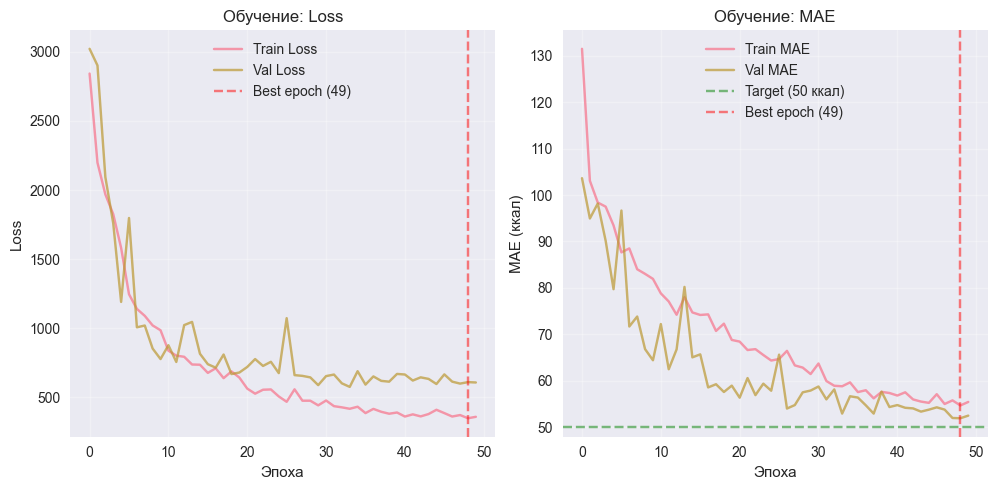


–°–¢–ê–¢–ò–°–¢–ò–ö–ê –û–ë–£–ß–ï–ù–ò–Ø:
–û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —ç–ø–æ—Ö: 50
–ù–∞—á–∞–ª—å–Ω—ã–π Val MAE: 103.64 –∫–∫–∞–ª
–ö–æ–Ω–µ—á–Ω—ã–π Val MAE: 52.49 –∫–∫–∞–ª
–£–ª—É—á—à–µ–Ω–∏–µ MAE: 51.15 –∫–∫–∞–ª
–õ—É—á—à–∏–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç: 51.92 –∫–∫–∞–ª

–¶–µ–ª—å –Ω–µ –¥–æ—Å—Ç–∏–≥–Ω—É—Ç–∞: MAE=51.92 >= 50 –∫–∫–∞–ª

–ê—Ä—Ç–µ—Ñ–∞–∫—Ç –º–æ–¥–µ–ª–∏ —Å–æ—Ö—Ä–∞–Ω–µ–Ω: models\best_model.pth
–ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è: configs/config.yaml


In [44]:
# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ –∏ —Ñ–∏–Ω–∞–ª—å–Ω–∞—è –æ—Ü–µ–Ω–∫–∞
import matplotlib.pyplot as plt

# –ò–∑–≤–ª–µ–∫–∞–µ–º –¥–∞–Ω–Ω—ã–µ –∏–∑ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ –æ–±—É—á–µ–Ω–∏—è
train_losses = training_results['train_losses']
val_losses = training_results['val_losses'] 
train_maes = training_results['train_maes']
val_maes = training_results['val_maes']
best_mae = training_results['best_mae']
best_epoch = training_results['best_epoch']

plt.figure(figsize=(15, 5))

# –ì—Ä–∞—Ñ–∏–∫ Loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', alpha=0.7)
plt.plot(val_losses, label='Val Loss', alpha=0.7)
plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best epoch ({best_epoch+1})')
plt.title('–û–±—É—á–µ–Ω–∏–µ: Loss')
plt.xlabel('–≠–ø–æ—Ö–∞')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# –ì—Ä–∞—Ñ–∏–∫ MAE
plt.subplot(1, 3, 2)
plt.plot(train_maes, label='Train MAE', alpha=0.7)
plt.plot(val_maes, label='Val MAE', alpha=0.7)
plt.axhline(y=config['target_mae'], color='green', linestyle='--', alpha=0.5, label=f'Target ({config["target_mae"]} –∫–∫–∞–ª)')
plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best epoch ({best_epoch+1})')
plt.title('–û–±—É—á–µ–Ω–∏–µ: MAE')
plt.xlabel('–≠–ø–æ—Ö–∞')
plt.ylabel('MAE (–∫–∫–∞–ª)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n–°–¢–ê–¢–ò–°–¢–ò–ö–ê –û–ë–£–ß–ï–ù–ò–Ø:")
print(f"–û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —ç–ø–æ—Ö: {len(train_losses)}")
print(f"–ù–∞—á–∞–ª—å–Ω—ã–π Val MAE: {val_maes[0]:.2f} –∫–∫–∞–ª")
print(f"–ö–æ–Ω–µ—á–Ω—ã–π Val MAE: {val_maes[-1]:.2f} –∫–∫–∞–ª")
print(f"–£–ª—É—á—à–µ–Ω–∏–µ MAE: {val_maes[0] - val_maes[-1]:.2f} –∫–∫–∞–ª")
print(f"–õ—É—á—à–∏–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç: {best_mae:.2f} –∫–∫–∞–ª")

# –§–∏–Ω–∞–ª—å–Ω–∞—è –æ—Ü–µ–Ω–∫–∞
target_mae = config['target_mae']
if best_mae < target_mae:
    print(f"\n–ó–ê–î–ê–ß–ê –í–´–ü–û–õ–ù–ï–ù–ê! MAE={best_mae:.2f} < {target_mae} –∫–∫–∞–ª")
    print("–ú–æ–¥–µ–ª—å –≥–æ—Ç–æ–≤–∞ –∫ –ø—Ä–æ–¥—É–∫—Ç–∏–≤–Ω–æ–º—É –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—é!")
else:
    print(f"\n–¶–µ–ª—å –Ω–µ –¥–æ—Å—Ç–∏–≥–Ω—É—Ç–∞: MAE={best_mae:.2f} >= {target_mae} –∫–∫–∞–ª")

# –ü—É—Ç—å –∫ –º–æ–¥–µ–ª–∏ –∏–∑ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏
model_path = os.path.join(config['output_dir'], 'best_model.pth')
config_path = "configs/config.yaml"

print(f"\n–ê—Ä—Ç–µ—Ñ–∞–∫—Ç –º–æ–¥–µ–ª–∏ —Å–æ—Ö—Ä–∞–Ω–µ–Ω: {model_path}")
print(f"–ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è: {config_path}")